In [187]:
%pylab inline
import pandas as pd
from scipy import stats
import os, datetime
from datetime import datetime, timedelta
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN, AgglomerativeClustering 
import matplotlib.cm as cm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from itertools import product

Populating the interactive namespace from numpy and matplotlib


In [2]:
LonFrom = -74.25559
LonTo = -73.70001
LatFrom = 40.49612
LatTo = 40.91553
#regions = pd.read_csv("regions.csv",";")

def preprocess(tripdata):
    return tripdata[(tripdata['trip_distance'] != 0) & 
          (tripdata['passenger_count'] != 0) &
          (tripdata['tpep_pickup_datetime'] != tripdata['tpep_dropoff_datetime']) &
          (tripdata['pickup_longitude'] > LonFrom) &
          (tripdata['pickup_longitude'] < LonTo) &
          (tripdata['pickup_latitude'] > LatFrom) &
          (tripdata['pickup_latitude'] < LatTo)]

# Gets lat,lon and returns the region
def getRegion (longitude, latitude):
    binsX = np.linspace(LonFrom, LonTo, 51)
    binsY = np.linspace(LatFrom, LatTo, 51)
    reg = stats.binned_statistic_2d(longitude, latitude, None, 
                                              statistic = "count", bins = [binsX, binsY], expand_binnumbers=True)
    return (reg.binnumber[0] - 1) * 50 + reg.binnumber[1]

#gets initial timeseries dataframe and returns a dataframe "tpep_pickup_datetime - region - counts"
def group_data_by_regions(tripdata):
    tripdata['region'] = getRegion(tripdata.pickup_longitude, tripdata.pickup_latitude)

    tripdata.loc[:,'tpep_pickup_datetime'] = tripdata.tpep_pickup_datetime.dt.floor('h')

    tripdata_grouped = tripdata.groupby(['tpep_pickup_datetime', 'region']).size().reset_index(name='counts')
    tripdata_grouped = tripdata_grouped.set_index('tpep_pickup_datetime')
    tripdata_grouped = tripdata_grouped.sort_values(by=['region', 'tpep_pickup_datetime'])
    return tripdata_grouped

#gets a timeseries and returns a timeseries but filled for every hours
def allregions_timeseries_everyhour (tripdata, regions_range):
    time_range = pd.date_range(start="2016-04-01 00:00:00", end = '2016-06-30 23:00:00', freq = 'H' )
    tripdata_full = pd.DataFrame()
    temp_df = pd.DataFrame()

    for region in regions_range:
        temp_df["tpep_pickup_datetime"] = time_range
        temp_df["region"] = region
        temp_df["counts"] = 0
        tripdata_full = tripdata_full.append(temp_df)

    tripdata_full = tripdata_full.set_index('tpep_pickup_datetime').sort_values(by=['region', 'tpep_pickup_datetime'])
    
    tripdata_grouped = group_data_by_regions(tripdata)

    tripdata_full_data = pd.merge_asof(tripdata_full, tripdata_grouped, on='region', 
                                                                   by = ['tpep_pickup_datetime','region'])

    tripdata_full_data = tripdata_full_data.fillna(0)
    return tripdata_full_data



Let's find regions where I will do predictions (more than 5 trips per hour in May'16)

In [3]:
tripdata = pd.read_csv("rawdata/yellow_tripdata_2016-05.csv",",", 
                       parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])

tripdata = preprocess(tripdata)
tripdata['region'] = getRegion(tripdata.pickup_longitude, tripdata.pickup_latitude)
nonempty_regions_count = tripdata["region"].value_counts()
nonempty_regions_count = (nonempty_regions_count).to_frame()
nonempty_regions_count.columns = ['counts']
nonempty_regions_count.index.name = 'region'
nonempty_regions_count = nonempty_regions_count.sort_values(by=['region'])
nonempty_regions_count.reset_index(level=0, inplace=True)

nonempty_regions_count["average_per_hour"] = nonempty_regions_count["counts"]/744
regions_more_than_5_trips_per_hour = nonempty_regions_count[nonempty_regions_count["average_per_hour"] > 5]

regions_to_predict = asarray(regions_more_than_5_trips_per_hour["region"])


Preparing a timeseries for selected 102 regions from 1st Apr'16 - 31st June'16

In [4]:
tripdata_full = pd.DataFrame()
tripdata_temp = pd.DataFrame()
for filename in os.listdir("rawdata"):
    print("started processing " + filename)
    if filename.endswith("csv"): 
        tripdata_temp = pd.read_csv("rawdata/" + filename,",", 
                           parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])
        tripdata_temp = preprocess(tripdata_temp)
        tripdata_temp['region'] = getRegion(tripdata_temp.pickup_longitude, tripdata_temp.pickup_latitude)
        tripdata_full = tripdata_full.append(tripdata_temp[tripdata_temp.region.isin(regions_to_predict)])

dataset_filtered_regions = allregions_timeseries_everyhour(tripdata_full, regions_to_predict)
dataset_filtered_regions = dataset_filtered_regions.set_index('tpep_pickup_datetime')
dataset_filtered_regions = dataset_filtered_regions.drop(columns = ['counts_x'])

started processing .DS_Store
started processing yellow_tripdata_2016-04.csv


KeyboardInterrupt: 

In [6]:
dataset_filtered_regions.tail()

region  counts_y
tpep_pickup_datetime                  
2016-06-30 19:00:00     2168       1.0
2016-06-30 20:00:00     2168       0.0
2016-06-30 21:00:00     2168       1.0
2016-06-30 22:00:00     2168       0.0
2016-06-30 23:00:00     2168       0.0

In [7]:
df_regions = pd.DataFrame()
df_regions["time"] = pd.date_range(start="2016-04-01 00:00:00", end = '2016-06-30 23:00:00', freq = 'H' )

for region in regions_to_predict:
    df_regions[str(region)] = list(dataset_filtered_regions[dataset_filtered_regions["region"] 
                                                             == region]["counts_y"])
df_regions = df_regions.set_index('time')
df_regions.to_csv("w4_all_regions.csv", sep=',')

In [8]:
df_regions.loc['2016-01-01':'2016-04-30'].head()

1075  1076  1077  1125   1126   1127   1128   1129  \
time                                                                      
2016-04-01 00:00:00  46.0  55.0  31.0  67.0  171.0  300.0  521.0  603.0   
2016-04-01 01:00:00  25.0  44.0  16.0  46.0   90.0  228.0  325.0  436.0   
2016-04-01 02:00:00  12.0  23.0  13.0  20.0   58.0  146.0  177.0  299.0   
2016-04-01 03:00:00   8.0   9.0   4.0  20.0   32.0  141.0   70.0  164.0   
2016-04-01 04:00:00   9.0  13.0   4.0  16.0   33.0  115.0   55.0  129.0   

                      1130   1131  ...  1630  1684  1733   1734  1783   2068  \
time                               ...                                         
2016-04-01 00:00:00  716.0  161.0  ...   4.0   0.0   2.0  158.0  50.0  104.0   
2016-04-01 01:00:00  598.0  121.0  ...   8.0   0.0   4.0    3.0  16.0   67.0   
2016-04-01 02:00:00  557.0   55.0  ...   9.0   0.0   0.0    0.0   1.0   18.0   
2016-04-01 03:00:00  498.0   52.0  ...   4.0   0.0   2.0    0.0   0.0    0.0   
2016-04-01 04:00:00  239.0   21.0  ...   8.0   1.0   3.0    3.0   2.0    1.0   

                     2069   2118  2119  2168  
time                                          
2016-04-01 00:00:00  14.0  175.0  53.0  96.0  
2016-04-01 01:00:00  14.0  165.0  13.0  68.0  
2016-04-01 02:00:00   2.0   26.0   0.0   7.0  
2016-04-01 03:00:00   0.0    6.0   0.0   1.0  
2016-04-01 04:00:00   0.0   10.0   0.0   1.0  

[5 rows x 102 columns]

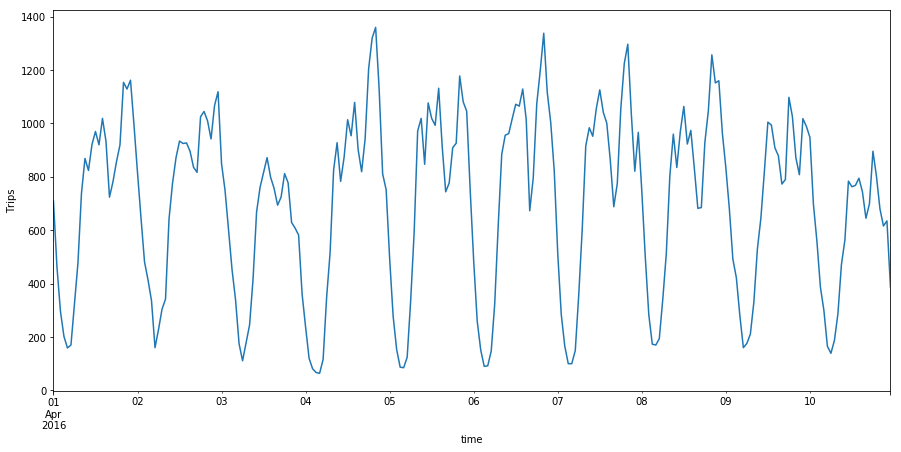

In [9]:
plt.figure(figsize(15,7))
df_regions.loc['2016-04-01':'2016-04-10']["1231"].plot()
plt.ylabel('Trips')
pylab.show()

<h1>Above was just prepartion of data. You can start from below

In [7]:
tripdata = pd.read_csv("w4_all_regions.csv",",",parse_dates=['time'], index_col = "time")

<h2> Let's normalize columns

In [8]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
df_regions_normalized = pd.DataFrame(StandardScaler().fit_transform(tripdata), index = tripdata.index, columns=tripdata.columns)
df_regions_normalized= df_regions_normalized.round(5)
df_regions_normalized.head()

1075     1076     1077     1125     1126     1127  \
time                                                                        
2016-04-01 00:00:00 -0.52790 -1.02808 -0.98730 -0.01302 -0.17351  0.21763   
2016-04-01 01:00:00 -1.02011 -1.16215 -1.24148 -0.56788 -1.00239 -0.31477   
2016-04-01 02:00:00 -1.32481 -1.41810 -1.29231 -1.25486 -1.32985 -0.92110   
2016-04-01 03:00:00 -1.41857 -1.58873 -1.44482 -1.25486 -1.59591 -0.95808   
2016-04-01 04:00:00 -1.39513 -1.53998 -1.44482 -1.36055 -1.58568 -1.15033   

                        1128     1129     1130     1131  ...     1630  \
time                                                     ...            
2016-04-01 00:00:00  1.37637  1.38753  1.23334  0.24957  ... -0.21733   
2016-04-01 01:00:00  0.18030  0.50327  0.74688 -0.27516  ...  0.64333   
2016-04-01 02:00:00 -0.72286 -0.22214  0.57786 -1.14097  ...  0.85850   
2016-04-01 03:00:00 -1.37582 -0.93695  0.33464 -1.18032  ... -0.21733   
2016-04-01 04:00:00 -1.46736 -1.12227 -0.73309 -1.58699  ...  0.64333   

                        1684     1733     1734     1783     2068     2069  \
time                                                                        
2016-04-01 00:00:00 -0.95649 -0.84644 -0.35342 -0.95352  0.18223  0.39119   
2016-04-01 01:00:00 -0.95649 -0.34073 -1.43294 -1.20012 -0.43840  0.39119   
2016-04-01 02:00:00 -0.95649 -1.35215 -1.45384 -1.30892 -1.26031 -0.98756   
2016-04-01 03:00:00 -0.95649 -0.84644 -1.45384 -1.31617 -1.56224 -1.21735   
2016-04-01 04:00:00 -0.88183 -0.59359 -1.43294 -1.30166 -1.54546 -1.21735   

                        2118     2119     2168  
time                                            
2016-04-01 00:00:00  0.42270  0.25208  0.96681  
2016-04-01 01:00:00  0.29256 -0.74527  0.31415  
2016-04-01 02:00:00 -1.51635 -1.06940 -1.10772  
2016-04-01 03:00:00 -1.77662 -1.06940 -1.24757  
2016-04-01 04:00:00 -1.72457 -1.06940 -1.24757  

[5 rows x 102 columns]

Let's look at silhouettes of clasters for diffent amount of clusters (1..10) using 
MiniBatchKMeans and AgglomerativeClustering)

('For n_clusters =', 2, 'The average silhouette_score is :', 0.25301524551706484)


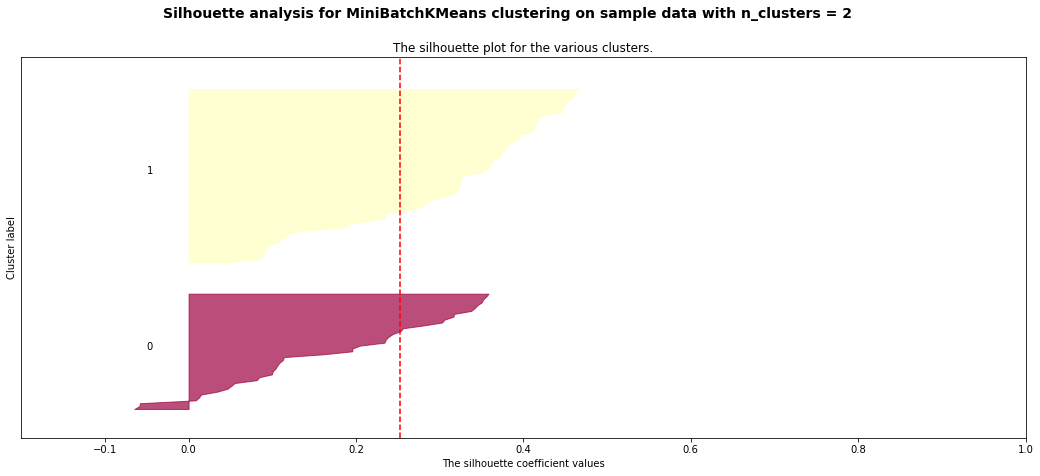

('For n_clusters =', 3, 'The average silhouette_score is :', 0.25678377613591585)


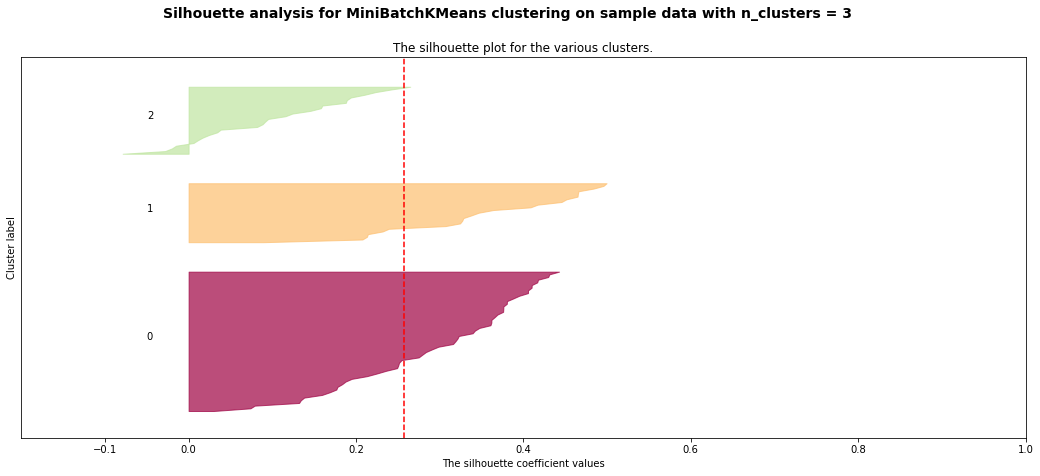

('For n_clusters =', 4, 'The average silhouette_score is :', 0.17733653867578192)


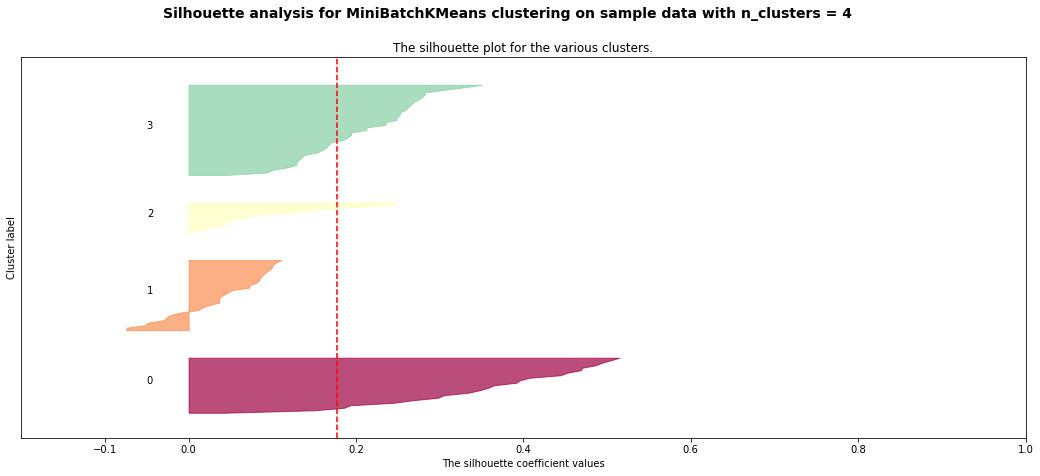

('For n_clusters =', 5, 'The average silhouette_score is :', 0.20555547913970548)


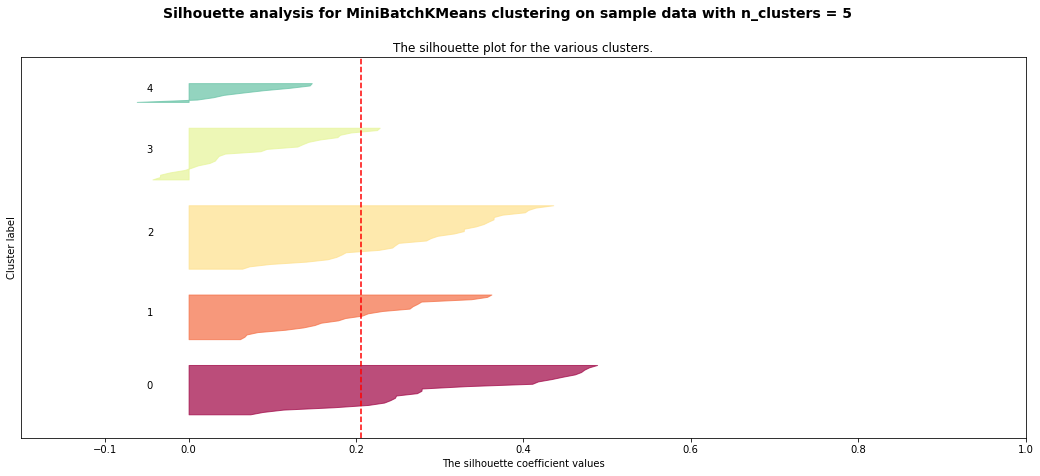

('For n_clusters =', 6, 'The average silhouette_score is :', 0.1766052411518976)


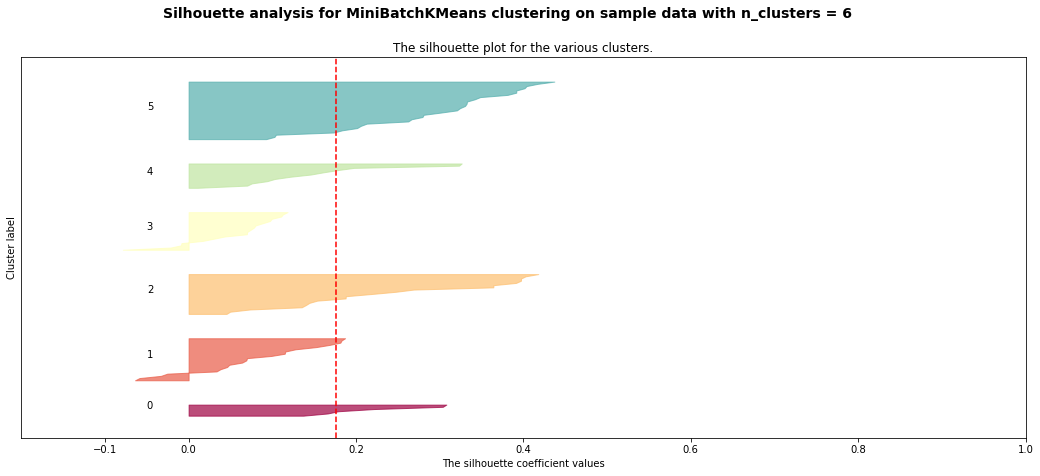

('For n_clusters =', 7, 'The average silhouette_score is :', 0.18917495901248674)


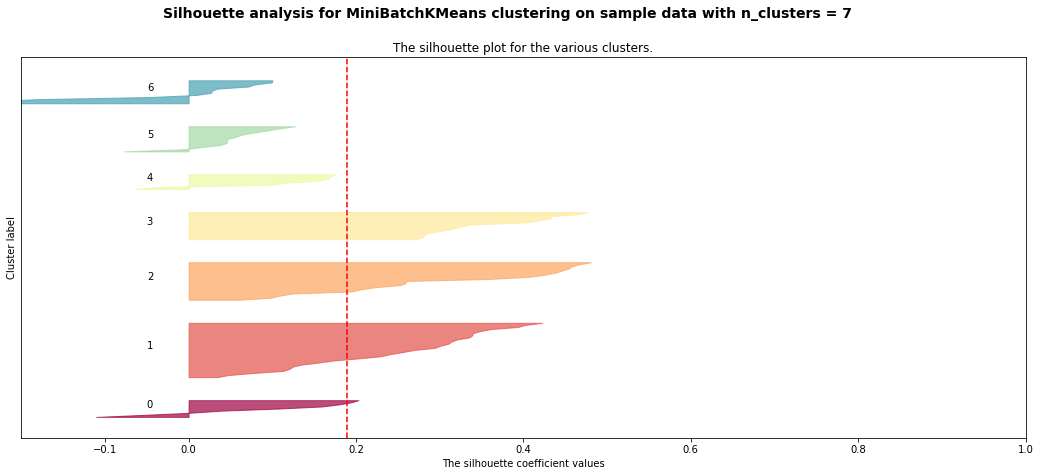

('For n_clusters =', 8, 'The average silhouette_score is :', 0.16830289560108602)


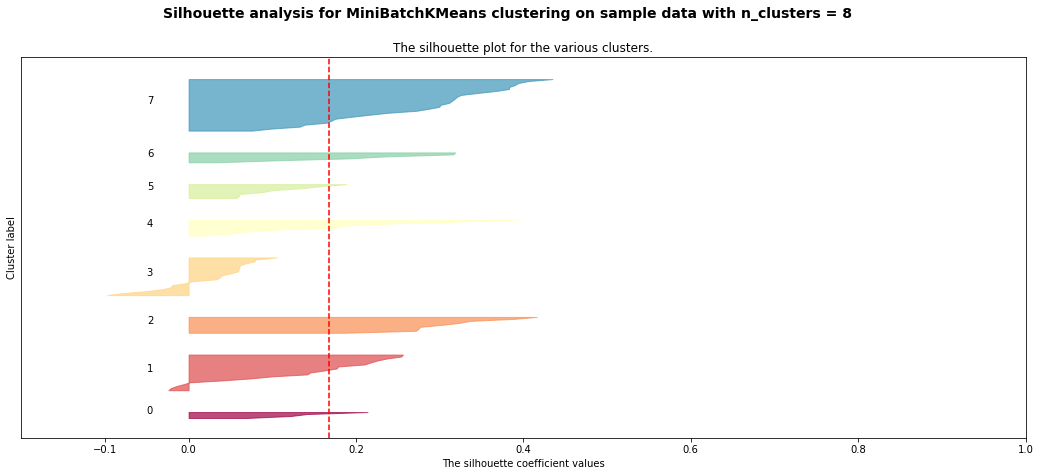

('For n_clusters =', 9, 'The average silhouette_score is :', 0.16881360336575063)


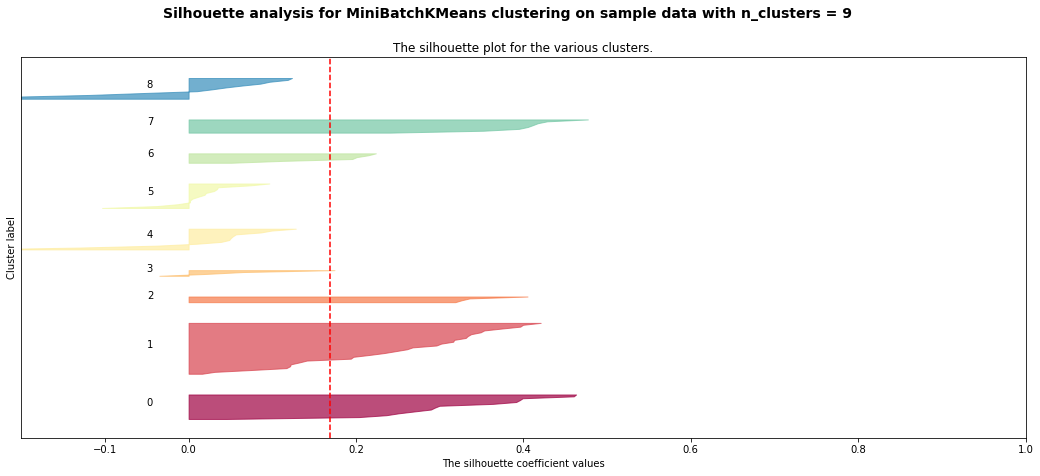

('For n_clusters =', 10, 'The average silhouette_score is :', 0.15798096850624838)


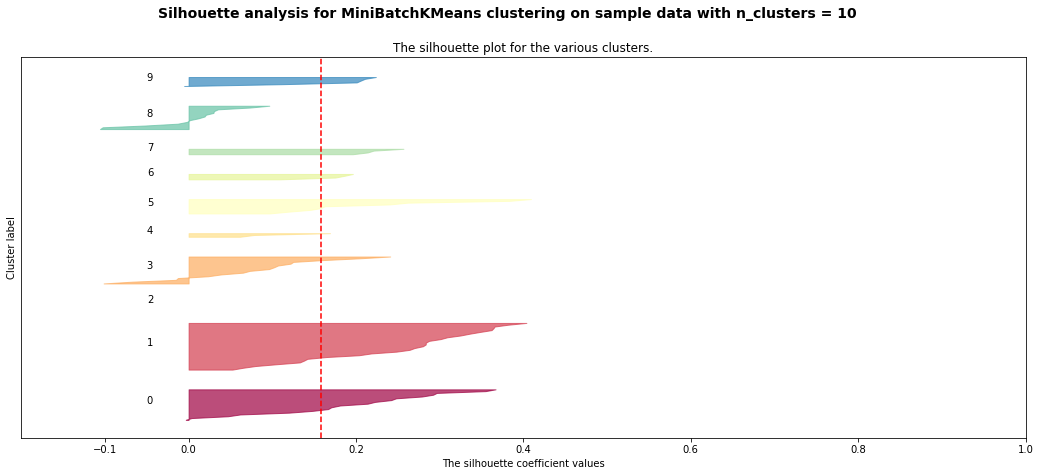

('For n_clusters =', 2, 'The average silhouette_score is :', 0.2392952646955571)


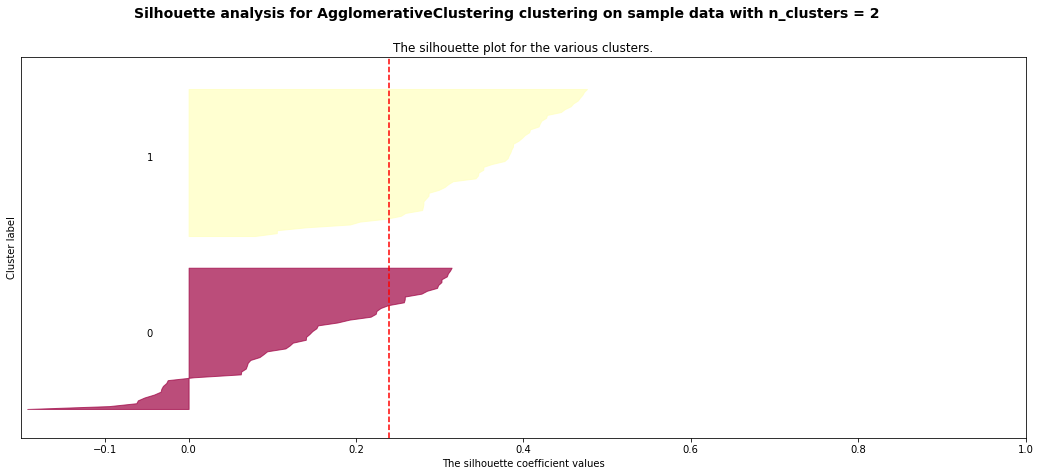

('For n_clusters =', 3, 'The average silhouette_score is :', 0.24420501139767026)


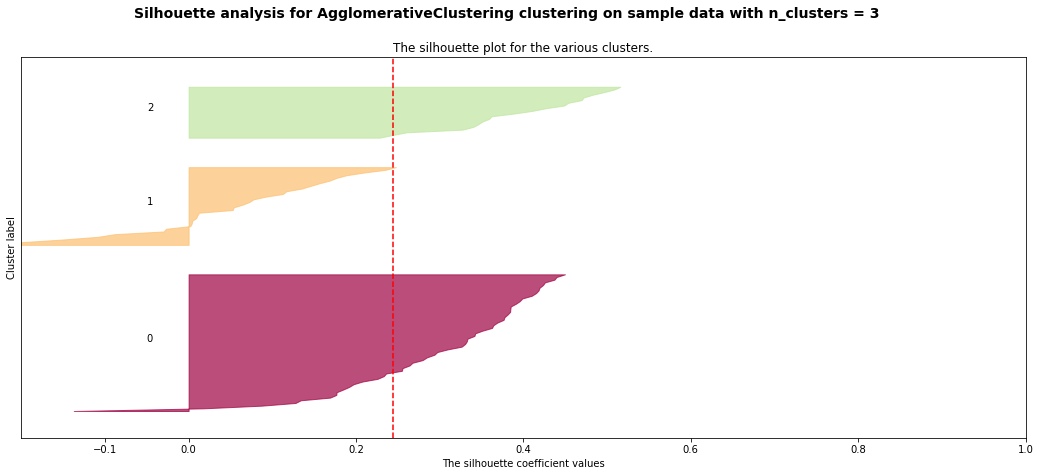

('For n_clusters =', 4, 'The average silhouette_score is :', 0.18567590248383106)


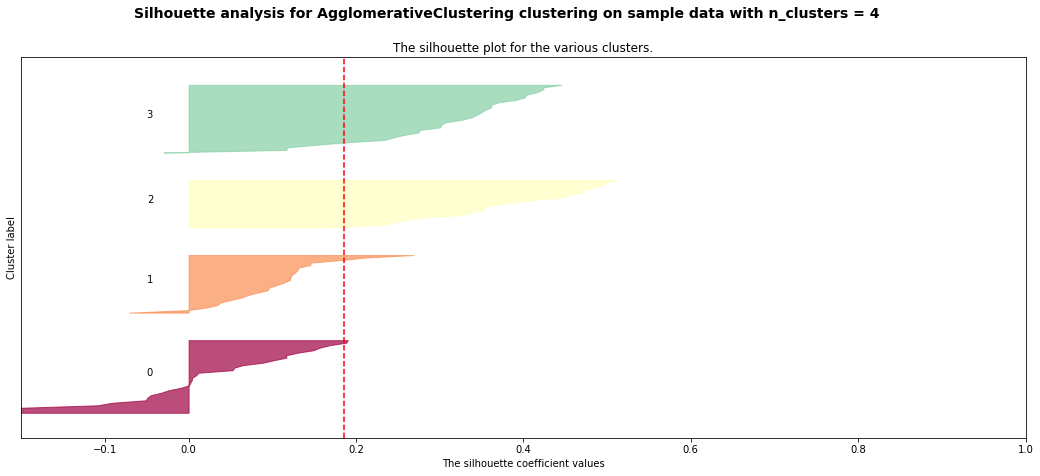

('For n_clusters =', 5, 'The average silhouette_score is :', 0.1978014766364617)


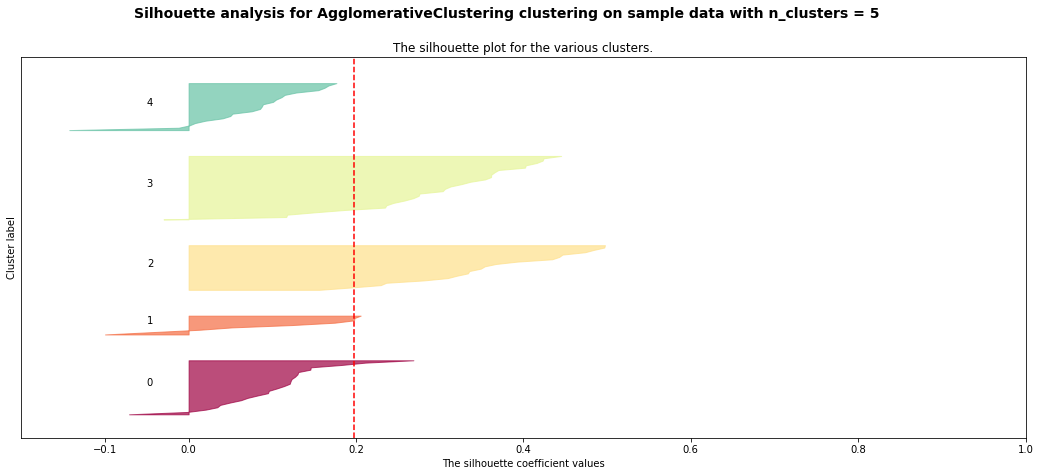

('For n_clusters =', 6, 'The average silhouette_score is :', 0.2014688040408469)


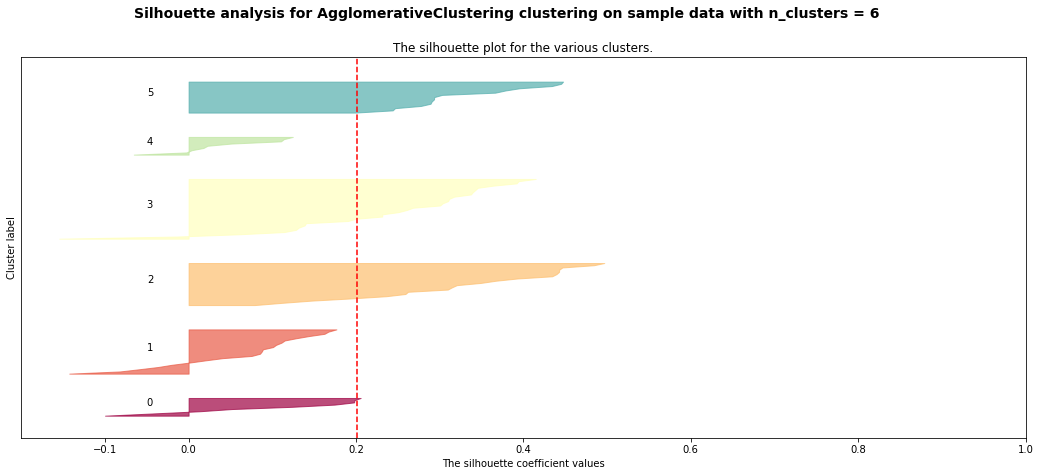

('For n_clusters =', 7, 'The average silhouette_score is :', 0.19728093537175015)


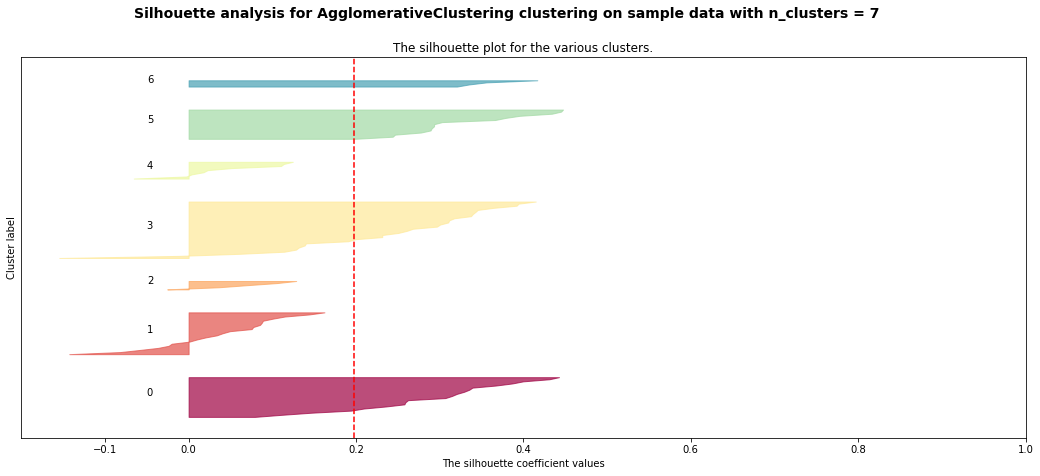

('For n_clusters =', 8, 'The average silhouette_score is :', 0.1831952742719241)


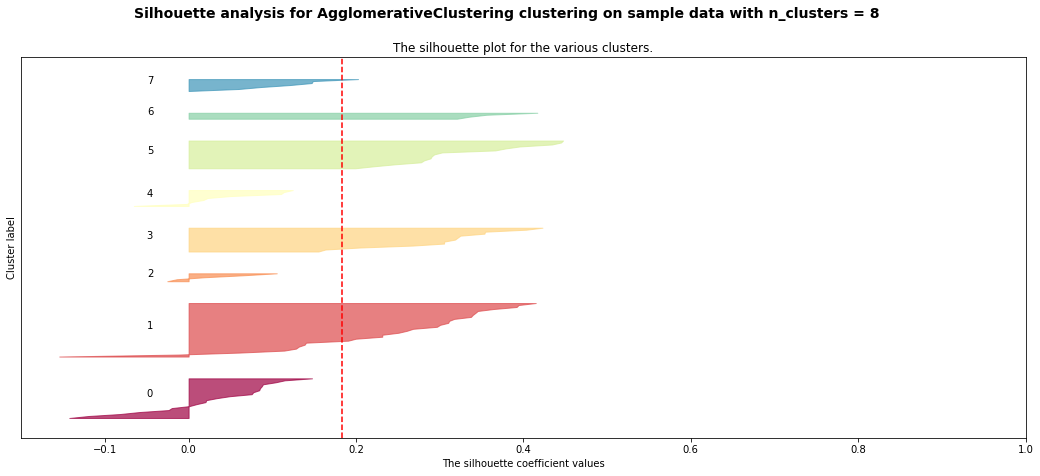

('For n_clusters =', 9, 'The average silhouette_score is :', 0.18811090698892127)


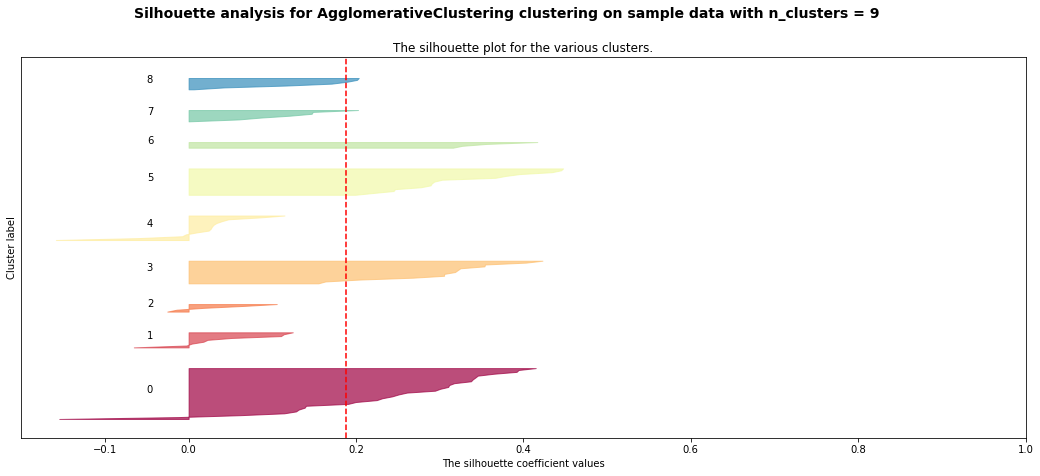

('For n_clusters =', 10, 'The average silhouette_score is :', 0.16295741035247055)


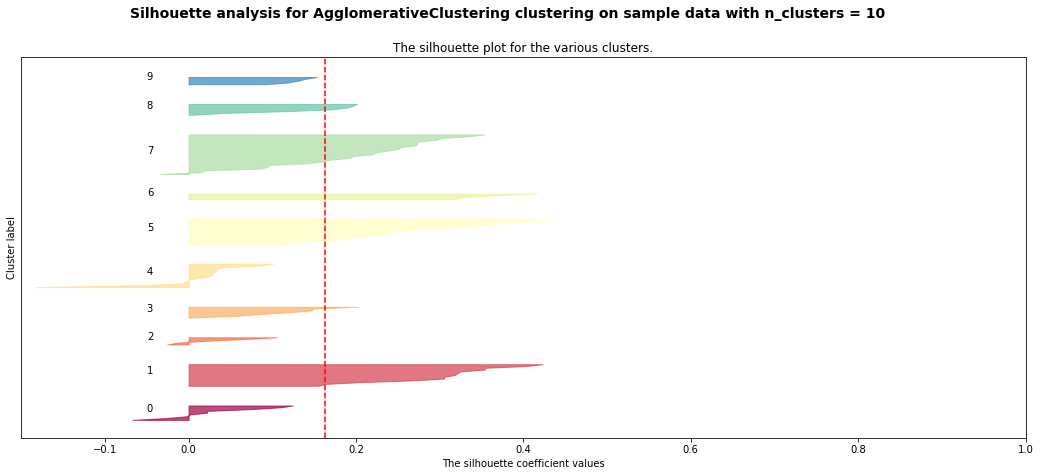

In [9]:
max_cluster = 10

for cluster_method in (MiniBatchKMeans, AgglomerativeClustering):
    for num_clusters in range(2, max_cluster+1):

        fig, ax1 = plt.subplots(1, 1)
        fig.set_size_inches(18, 7)

        ax1.set_xlim([-0.2, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(df_regions_normalized.columns) + (num_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        if cluster_method == AgglomerativeClustering:
            clusterer = cluster_method(n_clusters=num_clusters)
        elif  cluster_method == DBSCAN:  
            clusterer = cluster_method(eps=5000, algorithm='auto')
        else:
            clusterer = cluster_method(n_clusters=num_clusters, random_state=10)
        
        cluster_labels = clusterer.fit_predict(df_regions_normalized.T)
        #print(cluster_labels)

        # The silhouette_score gives the average value for all the samples. This gives a perspective into the density
        # and separation of the formed clusters
        silhouette_avg = silhouette_score(df_regions_normalized.T, cluster_labels)
        print("For n_clusters =", num_clusters, "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(df_regions_normalized.T, cluster_labels)

        y_lower = 10
        for i in range(num_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            cmap = cm.get_cmap("Spectral")
            color = cmap(float(i) / num_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        d = {MiniBatchKMeans:"MiniBatchKMeans", AgglomerativeClustering:"AgglomerativeClustering"}
        plt.suptitle(("Silhouette analysis for " + d[cluster_method] + " clustering on sample data "
                      "with n_clusters = %d" % num_clusters),
                     fontsize=14, fontweight='bold')

        plt.show()

Let's pick number of clusters = 3 (we can take more, but it means more or similar computations). And since we have the goal - education, we can do this sucessfully using 3 clusters. 

In [10]:
clusterer = MiniBatchKMeans(n_clusters = 3)
cluster_labels = clusterer.fit_predict(df_regions_normalized.T)
silhouette_avg = silhouette_score(df_regions_normalized.T, cluster_labels)

In [14]:
cluster_labels

array([1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 2, 2, 2, 2, 0, 0, 0, 1, 1, 1, 2,
       1, 1, 0, 0, 0, 0, 2, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 2, 2, 2, 2, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 0, 0, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [15]:
mapping = pd.DataFrame()
mapping["region"] = tripdata.columns
mapping["cluster"] = cluster_labels

In [16]:
pd.Series(clusterer.labels_).value_counts()

1    52
2    25
0    25
dtype: int64

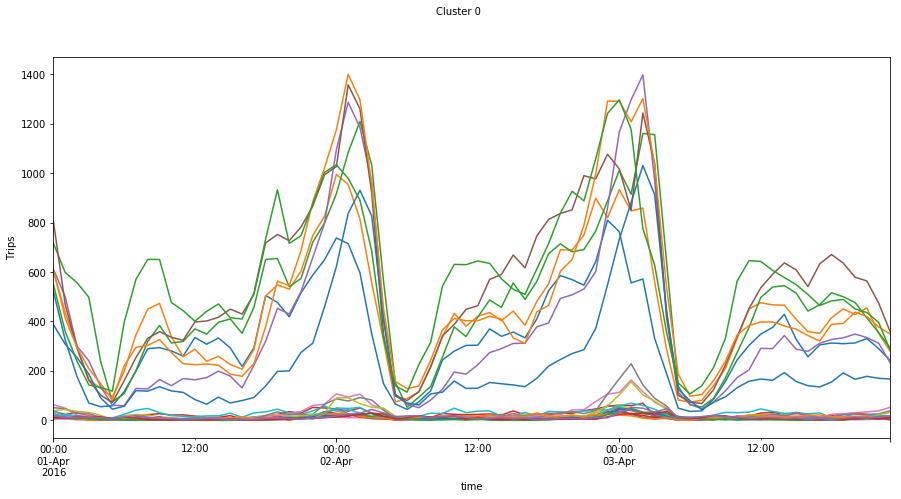

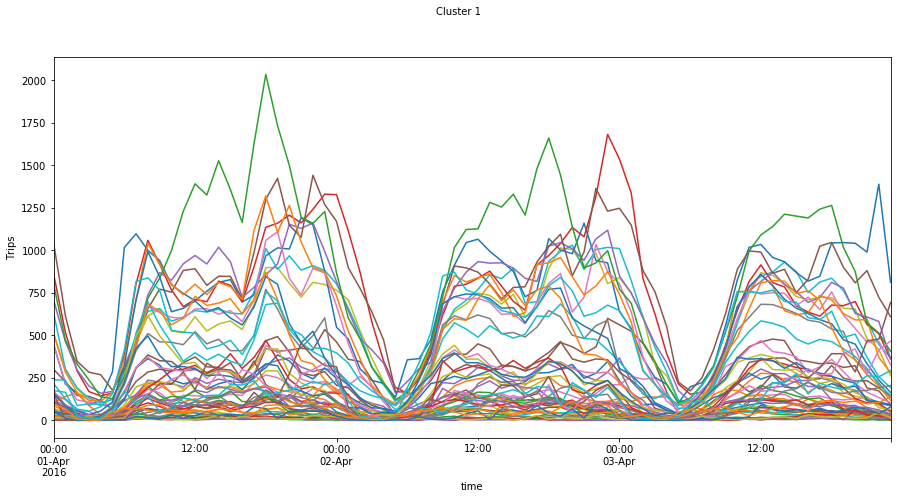

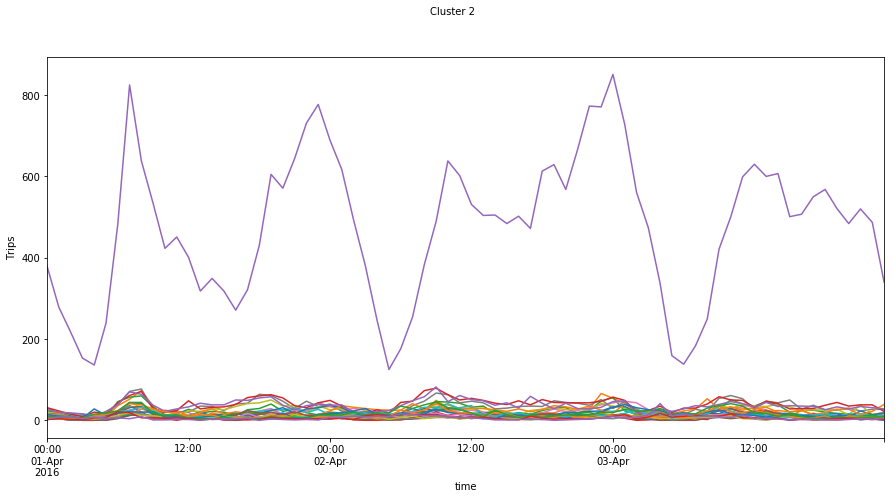

In [17]:
for i in range(3):
    plt.figure(figsize(15,7))
    for region in mapping[mapping["cluster"] == i]["region"]:
        plt.suptitle(("Cluster %d" %i), fontsize=10)
        tripdata.loc['2016-04-01':'2016-04-03'][str(region)].plot()
    plt.ylabel('Trips')
    pylab.show()

<h3> 4. For each cluster let's find the element closest to the center of cluster

In [18]:
from sklearn.metrics import pairwise_distances_argmin_min
df_regions_closest, _ = pairwise_distances_argmin_min(clusterer.cluster_centers_, df_regions_normalized.T)
centers_of_clusters = df_regions_normalized.T.iloc[df_regions_closest].T.columns

In [19]:
print df_regions_closest
print centers_of_clusters

[30 48 71]
Index([u'1228', u'1285', u'1387'], dtype='object')


<h3> 5. For the selected geographic zones, let's select the optimal structure of the models in the initial series - a set of regression characteristics and the values of the hyperparameters p, d, q, P, D, Q

In [20]:
date_from = datetime.datetime.strptime("2016-04-01 00:00:00", "%Y-%m-%d %H:%M:%S")
date_to = datetime.datetime.strptime("2016-04-30 23:00:00", "%Y-%m-%d %H:%M:%S")

let's set features for regression

In [93]:
tripdata_features = pd.DataFrame()
tripdata_features["time"] = pd.date_range(start="2016-04-01 00:00:00", end = '2016-06-30 23:00:00', freq = 'H' )
tripdata_features = tripdata_features.set_index('time')
K_least_mse = 35
for i in range(1, K_least_mse+1):        
        tripdata_features['s_'+str(i)] = np.sin(np.arange(1, tripdata_cluster_3.shape[0]+1)*2*np.pi*i/168)
        tripdata_features['c_'+str(i)] = np.cos(np.arange(1, tripdata_cluster_3.shape[0]+1)*2*np.pi*i/168)

<h5 >Cluster 1

<Figure size 1080x504 with 0 Axes>

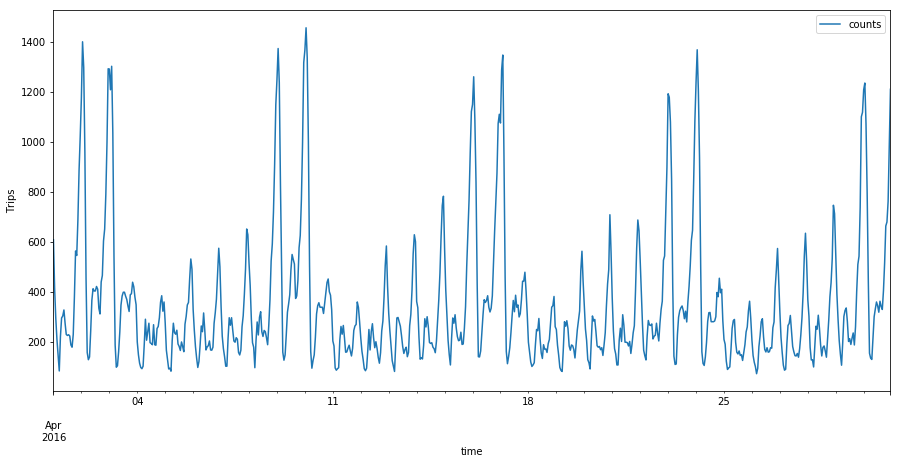

In [94]:
tripdata_cluster_1 = pd.DataFrame(tripdata[str(centers_of_clusters[0])])
tripdata_cluster_1 = tripdata_cluster_1.rename({str(centers_of_clusters[0]):"counts"}, axis='columns')

plt.figure(figsize(15,7))
tripdata_cluster_1.loc[date_from:date_to].plot()
plt.ylabel('Trips')
pylab.show()

In [95]:
X = tripdata_features.loc[date_from:date_to]
y = tripdata_cluster_1.loc[date_from:date_to].counts

linear_model = LinearRegression()
model_fit = linear_model.fit(X, y)
y_predicted = model_fit.predict(X)

print model_fit.score(X, y)

0.9764292887859913


In [96]:
tripdata_cluster_1.loc[date_from:date_to,'prediction'] = y_predicted
tripdata_cluster_1.loc[date_from:date_to,'residuals'] = y - y_predicted

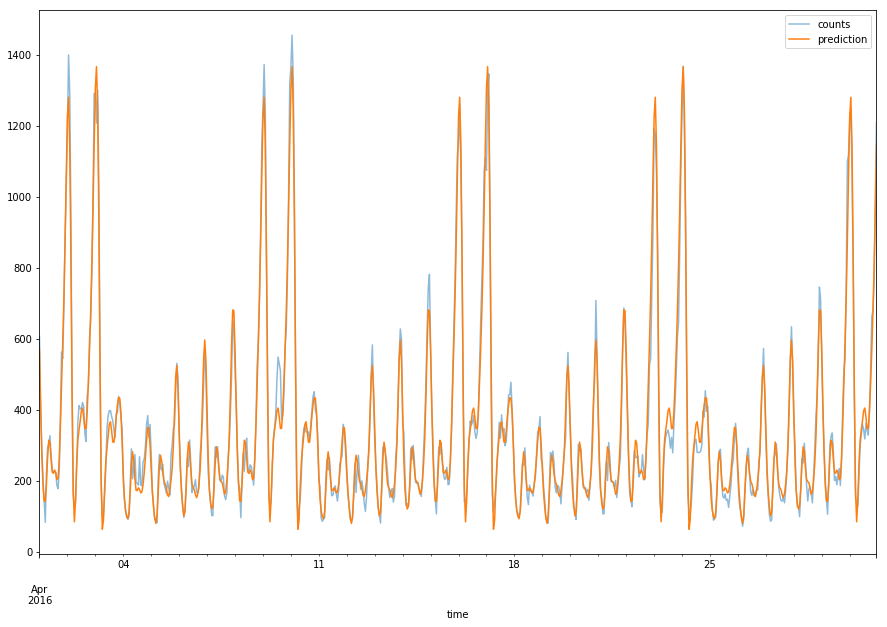

In [97]:
plt.figure(figsize(15, 10))
tripdata_cluster_1.loc[date_from:date_to]['counts'].plot(alpha = 0.5, legend = True)
tripdata_cluster_1.loc[date_from:date_to]['prediction'].plot(legend = True)

<Figure size 1080x720 with 0 Axes>

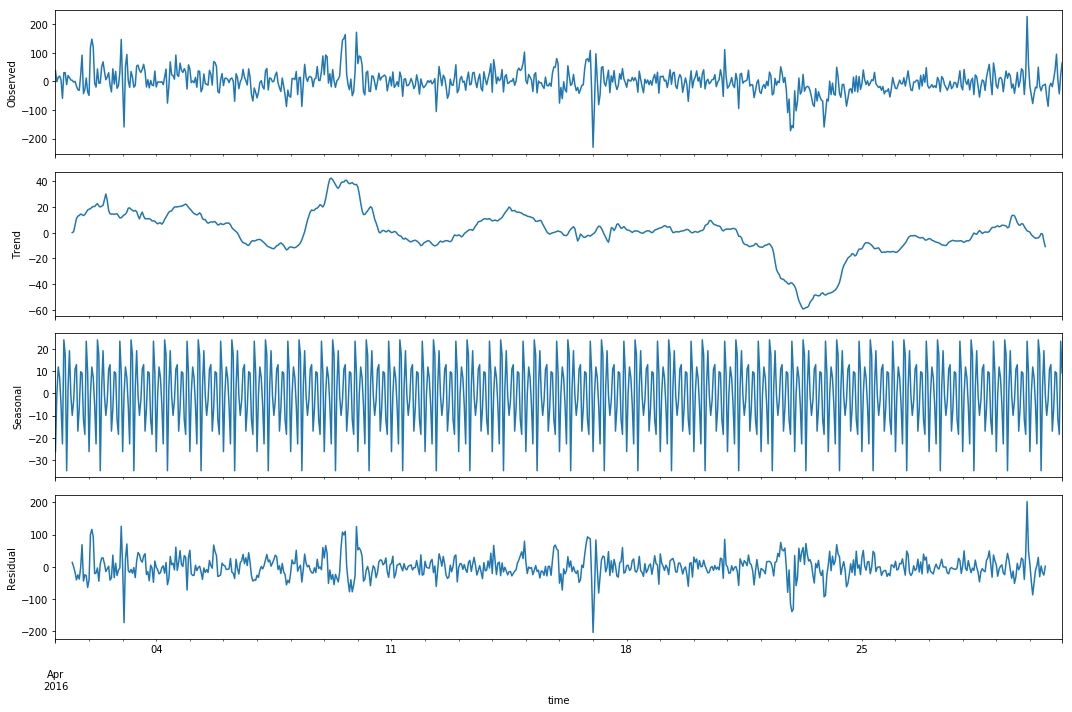

In [98]:
plt.figure(figsize(15, 10))
sm.tsa.seasonal_decompose(tripdata_cluster_1.loc[date_from:date_to,'residuals'], freq = 24).plot();

In [99]:
print "Dickey - Fuller test: p = ", sm.tsa.stattools.adfuller(tripdata_cluster_1.loc[date_from:date_to].counts)[1]

Dickey - Fuller test: p =  0.20149512515324391


<Figure size 1080x720 with 0 Axes>

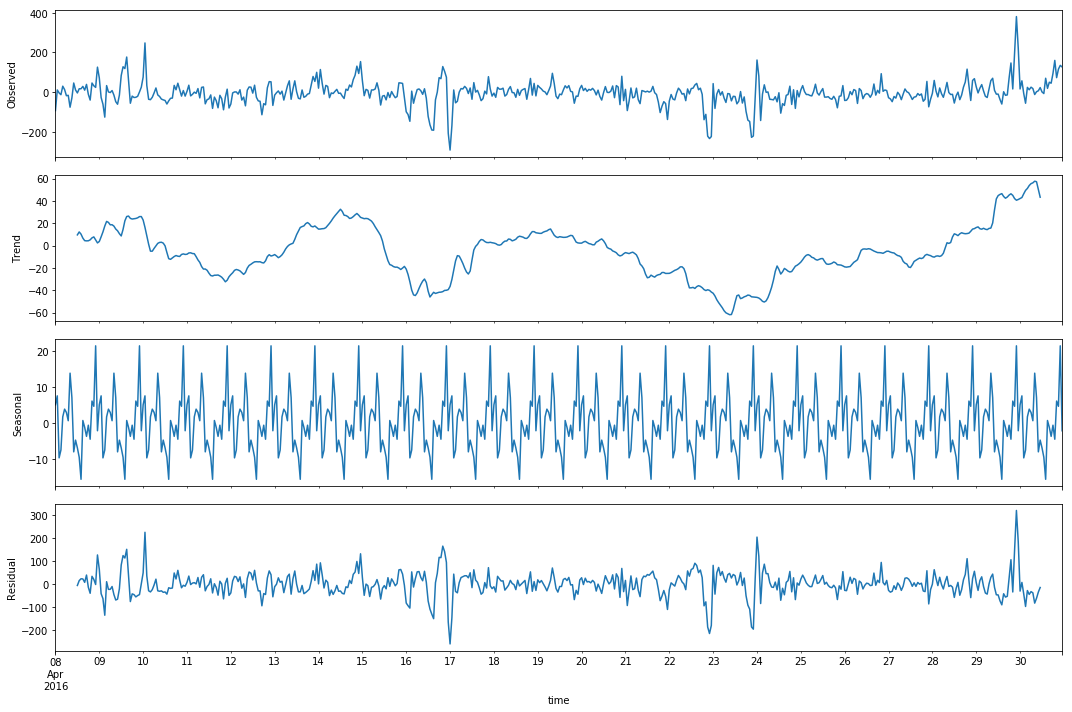

In [100]:
tripdata_cluster_1['residuals_dif'] = tripdata_cluster_1.loc[date_from:date_to].residuals - tripdata_cluster_1.residuals.shift(168)
plt.figure(figsize(15, 10))
sm.tsa.seasonal_decompose(tripdata_cluster_1[168:].loc[date_from:date_to, 
                                                       'residuals_dif'], freq = 24).plot();

<Figure size 1080x720 with 0 Axes>

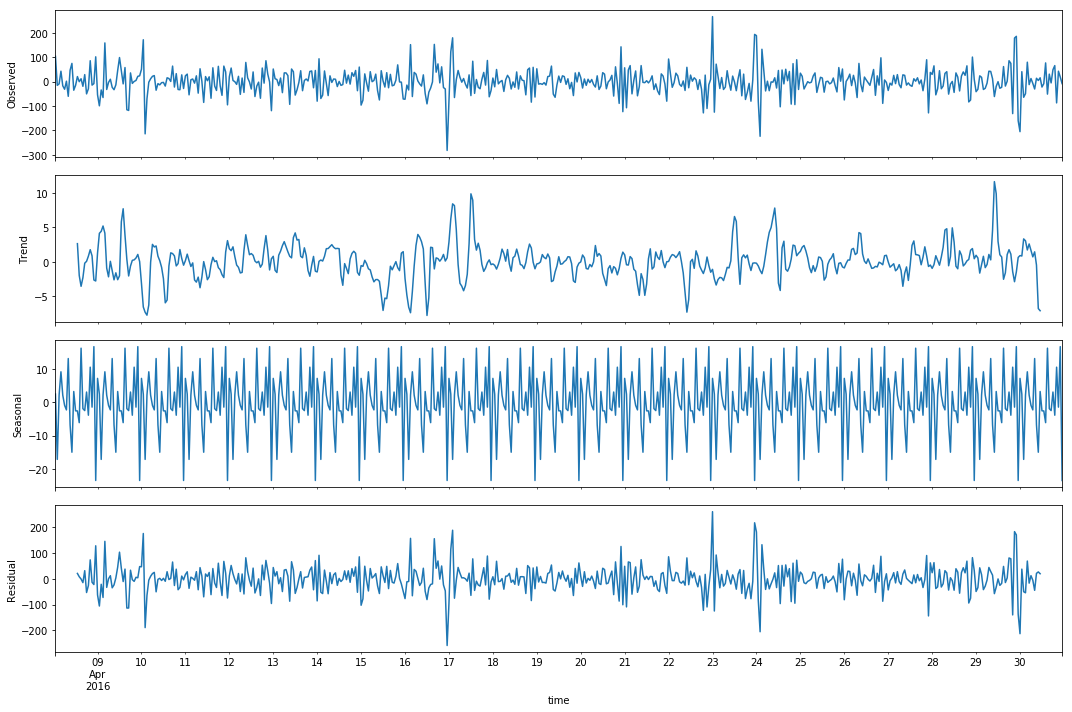

In [101]:
tripdata_cluster_1['residuals_dif2'] = tripdata_cluster_1.loc[date_from:date_to].residuals_dif-tripdata_cluster_1.loc[date_from:date_to].residuals_dif.shift(1)
plt.figure(figsize(15, 10))
sm.tsa.seasonal_decompose(tripdata_cluster_1[169:].loc[date_from:date_to, 'residuals_dif2'], freq = 24).plot();

In [102]:
print("Dickey - Fuller test: p = ", sm.tsa.stattools.adfuller(tripdata_cluster_1.loc[date_from:date_to].residuals_dif2[169:])[1])

('Dickey - Fuller test: p = ', 5.265202344367329e-16)


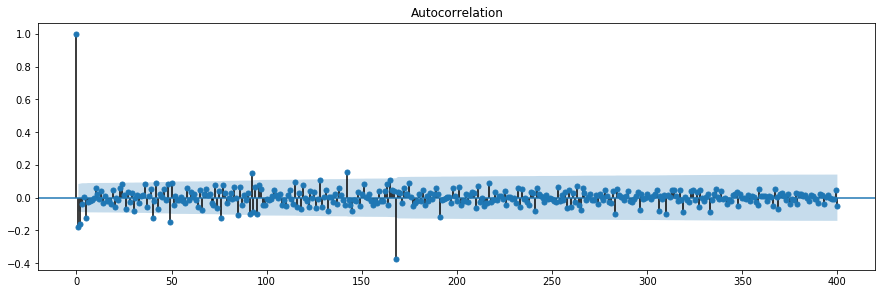

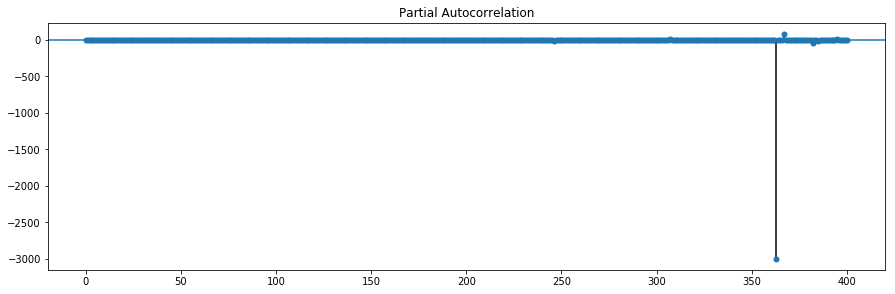

In [103]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(tripdata_cluster_1.loc[date_from:date_to].residuals_dif2[169:].values.squeeze(), lags = 400, ax = ax)
plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(tripdata_cluster_1.loc[date_from:date_to].residuals_dif2[169:].values.squeeze(), lags = 400, ax = ax)
plt.show()

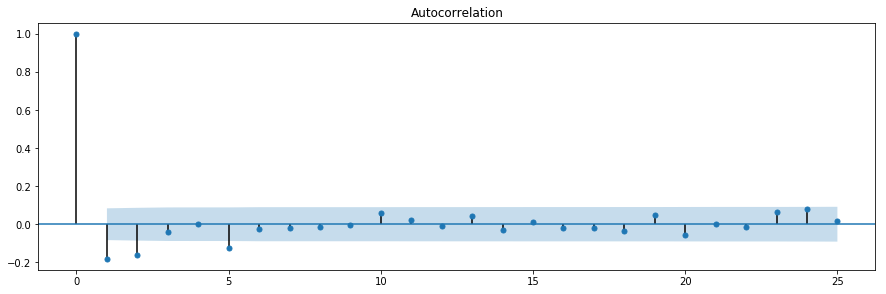

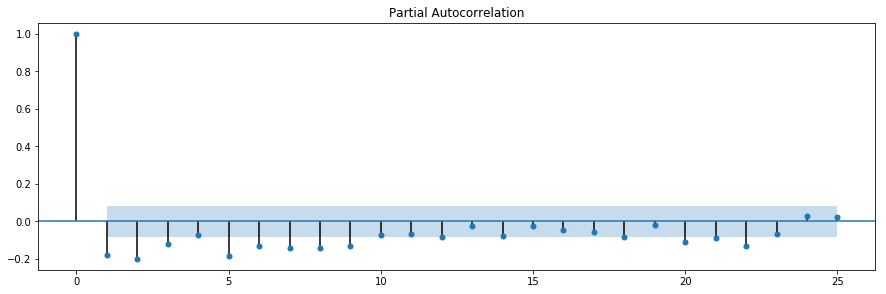

In [104]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(tripdata_cluster_1.loc[date_from:date_to].residuals_dif2[169:].values.squeeze(), lags = 25, ax = ax)
plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(tripdata_cluster_1.loc[date_from:date_to].residuals_dif2[169:].values.squeeze(), lags = 25, ax = ax)
plt.show()

In [105]:
Q = 1
q = 2
P = 0
p = 3

ps = range(0, p+1)
d = 0
qs = range(0, q+1)
Ps = range(0, P+1)
D = 0
Qs = range(0, Q+1)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

24

In [106]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #we need try except since the model will not not fit on some parameter sets
    try:
        model=sm.tsa.statespace.SARIMAX(
                                        endog=tripdata_cluster_1.loc[date_from:date_to].counts, 
                                        exog = asarray(tripdata_features.loc[date_from:date_to]),
                                        order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24), 
                                        initialization='approximate_diffuse'
                                       ).fit(disp=False)
    #вdisplay parameters on which the model didn't fit and proceed to the next set
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    print 'parameters:{} have aic value {}'.format(param, aic)
    #saving the best model, aic, parameters
    if aic < best_aic:
        best_model_cluster_1 = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

parameters:(0, 0, 0, 0) have aic value 10579.9690781
parameters:(0, 0, 0, 1) have aic value 9864.7022012
parameters:(0, 1, 0, 0) have aic value 9714.03033667
parameters:(0, 1, 0, 1) have aic value 9263.75364907
parameters:(0, 2, 0, 0) have aic value 9151.02496813
parameters:(0, 2, 0, 1) have aic value 8815.68523221
parameters:(1, 0, 0, 0) have aic value 7697.80685477
parameters:(1, 0, 0, 1) have aic value 7768.6747369
parameters:(1, 1, 0, 0) have aic value 7498.00328301
parameters:(1, 1, 0, 1) have aic value 7578.44642031
parameters:(1, 2, 0, 0) have aic value 7416.88294548
parameters:(1, 2, 0, 1) have aic value 7499.26588266
parameters:(2, 0, 0, 0) have aic value 7665.77791234
parameters:(2, 0, 0, 1) have aic value 7728.88781262
('wrong parameters:', (2, 1, 0, 0))
('wrong parameters:', (2, 1, 0, 1))
parameters:(2, 2, 0, 0) have aic value 7431.58896847
parameters:(2, 2, 0, 1) have aic value 7512.49760327
parameters:(3, 0, 0, 0) have aic value 7521.75026194
parameters:(3, 0, 0, 1) have 

In [107]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True))

      parameters           aic
10  (1, 2, 0, 0)   7416.882945
14  (2, 2, 0, 0)   7431.588968
20  (3, 2, 0, 0)   7447.050236
18  (3, 1, 0, 0)   7449.463450
8   (1, 1, 0, 0)   7498.003283
11  (1, 2, 0, 1)   7499.265883
15  (2, 2, 0, 1)   7512.497603
21  (3, 2, 0, 1)   7518.951722
16  (3, 0, 0, 0)   7521.750262
19  (3, 1, 0, 1)   7530.983287
9   (1, 1, 0, 1)   7578.446420
17  (3, 0, 0, 1)   7608.523049
12  (2, 0, 0, 0)   7665.777912
6   (1, 0, 0, 0)   7697.806855
13  (2, 0, 0, 1)   7728.887813
7   (1, 0, 0, 1)   7768.674737
5   (0, 2, 0, 1)   8815.685232
4   (0, 2, 0, 0)   9151.024968
3   (0, 1, 0, 1)   9263.753649
2   (0, 1, 0, 0)   9714.030337
1   (0, 0, 0, 1)   9864.702201
0   (0, 0, 0, 0)  10579.969078


In [49]:
print(best_model_cluster_1.summary())

                           Statespace Model Results                           
Dep. Variable:                 counts   No. Observations:                  720
Model:               SARIMAX(1, 0, 2)   Log Likelihood               -3639.445
Date:                Sat, 06 Jul 2019   AIC                           7424.891
Time:                        16:35:31   BIC                           7759.176
Sample:                    04-01-2016   HQIC                          7553.943
                         - 04-30-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1           157.1726      6.694     23.478      0.000     144.052     170.293
x2            49.3814      6.779      7.284      0.000      36.094      62.669
x3             7.8357      4.965      1.578      0.1

Let's analyse the model

Критерий Стьюдента: p=0.181585
Критерий Дики-Фуллера: p=0.000000


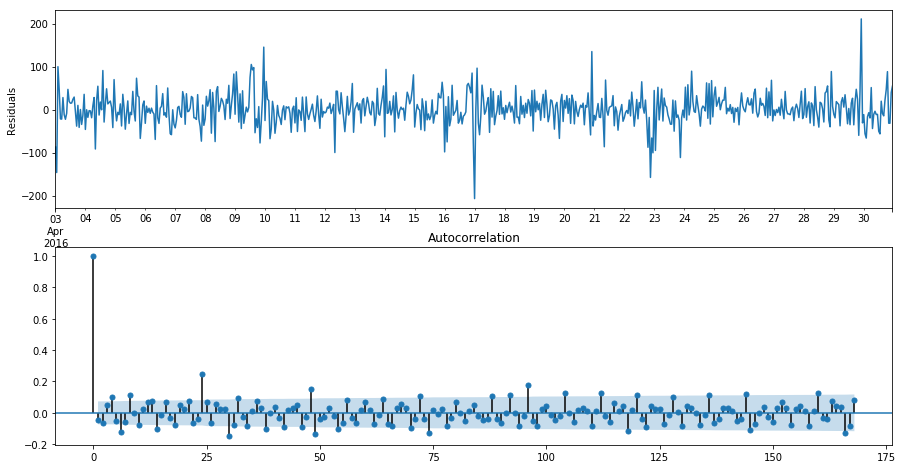

In [50]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model_cluster_1.resid.loc[date_from_1:date_to_1].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model_cluster_1.resid.values.squeeze(), lags=168, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model_cluster_1.resid, 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model_cluster_1.resid)[1])

<h5 >Cluster 2

<Figure size 1080x504 with 0 Axes>

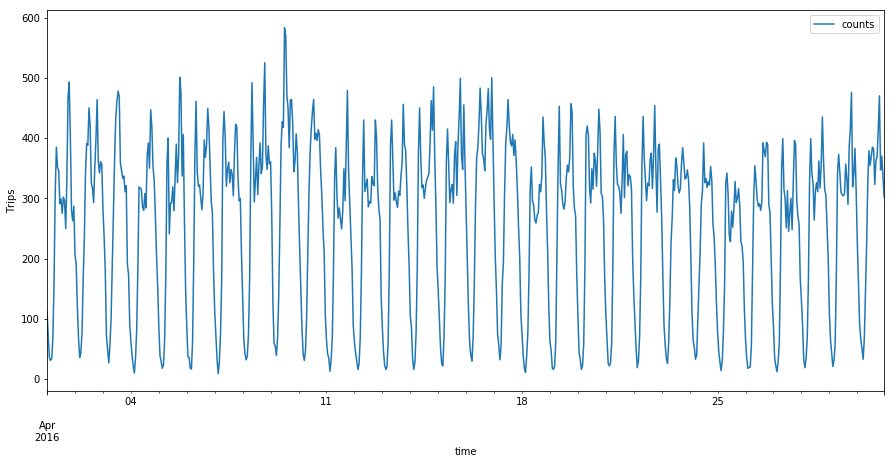

In [51]:
tripdata_cluster_2 = pd.DataFrame(tripdata[str(centers_of_clusters[1])])
tripdata_cluster_2 = tripdata_cluster_2.rename({str(centers_of_clusters[1]):"counts"}, axis='columns')

plt.figure(figsize(15,7))
tripdata_cluster_2.loc[date_from:date_to].plot()
plt.ylabel('Trips')
pylab.show()

In [52]:
X = tripdata_features.loc[date_from:date_to]
y = tripdata_cluster_2.loc[date_from:date_to].counts

linear_model = LinearRegression()
model_fit = linear_model.fit(X, y)
y_predicted = model_fit.predict(X)

print model_fit.score(X, y)

0.9400859744980368


In [53]:
tripdata_cluster_2.loc[date_from:date_to,'prediction'] = y_predicted
tripdata_cluster_2.loc[date_from:date_to,'residuals'] = y - y_predicted

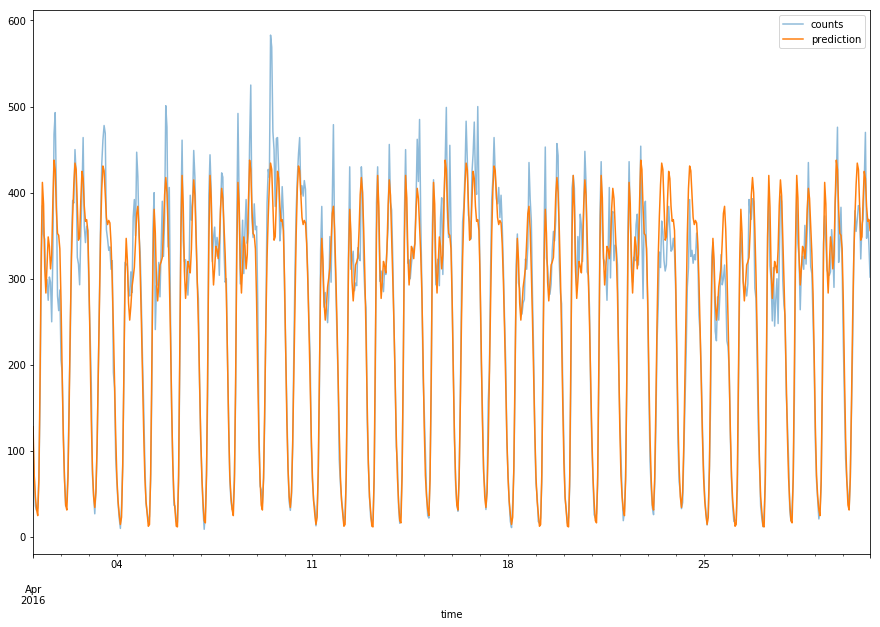

In [54]:
plt.figure(figsize(15, 10))
tripdata_cluster_2.loc[date_from:date_to]['counts'].plot(alpha = 0.5, legend = True)
tripdata_cluster_2.loc[date_from:date_to]['prediction'].plot(legend = True)

<Figure size 1080x720 with 0 Axes>

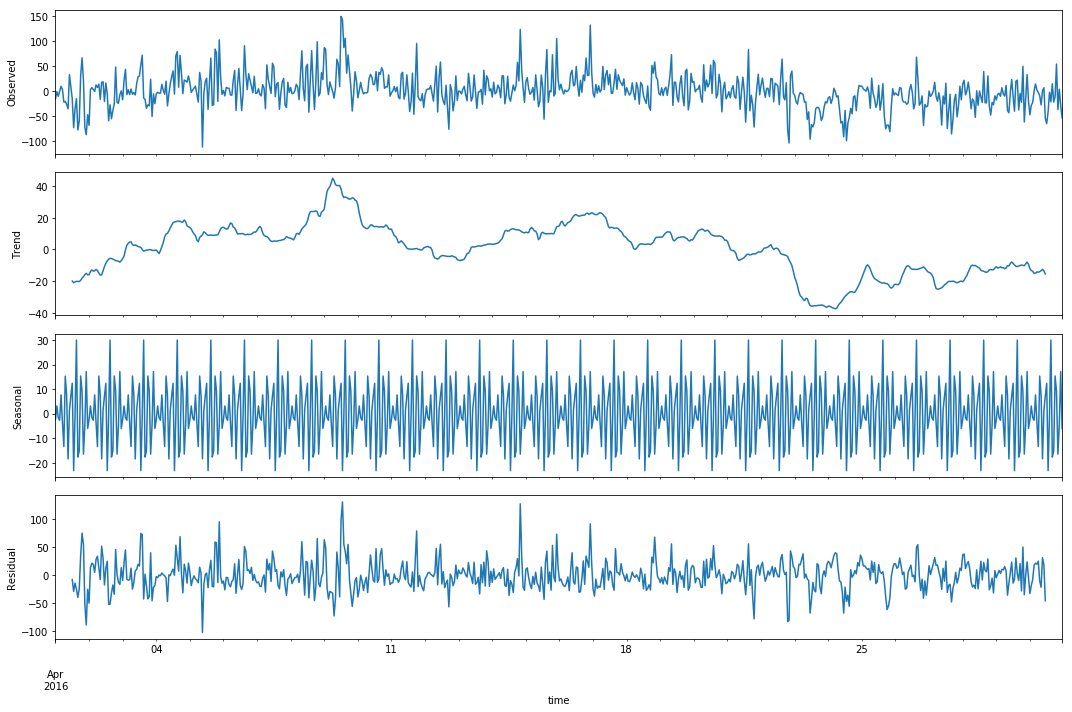

In [55]:
plt.figure(figsize(15, 10))
sm.tsa.seasonal_decompose(tripdata_cluster_2.loc[date_from:date_to,'residuals'], freq = 24).plot();

In [56]:
print "Dickey - Fuller test: p = ", sm.tsa.stattools.adfuller(tripdata_cluster_2.loc[date_from:date_to].counts)[1]

Dickey - Fuller test: p =  3.984584851827095e-06


<Figure size 1080x720 with 0 Axes>

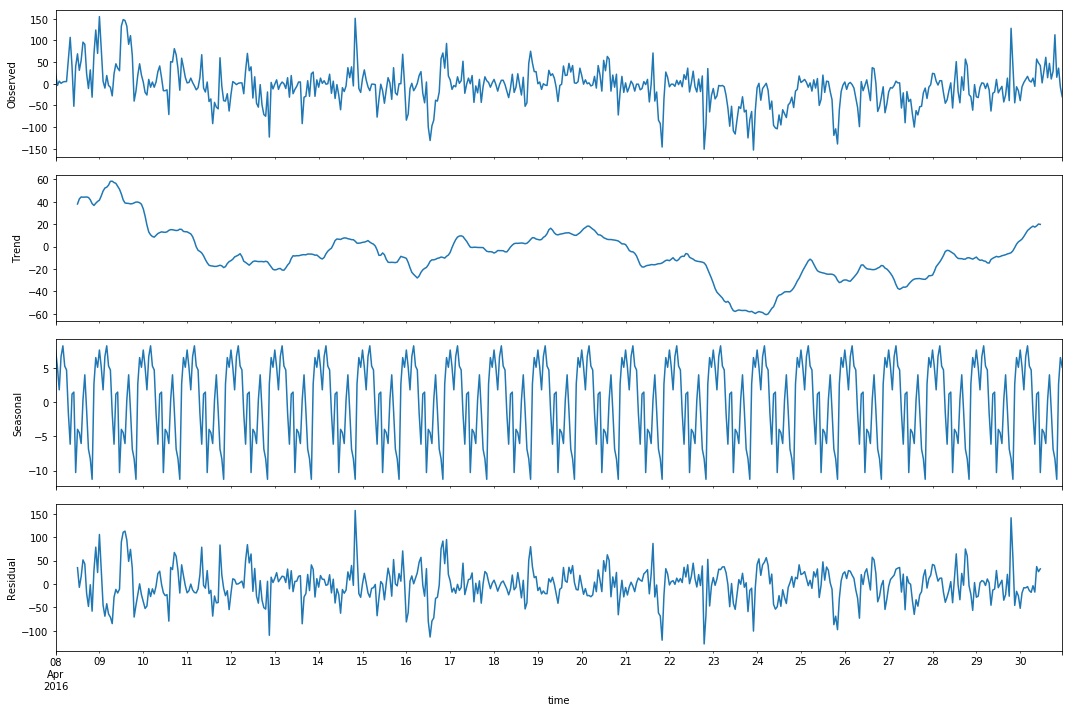

In [57]:
tripdata_cluster_2['residuals_dif'] = tripdata_cluster_2.loc[date_from:date_to].residuals - tripdata_cluster_2.residuals.shift(168)
plt.figure(figsize(15, 10))
sm.tsa.seasonal_decompose(tripdata_cluster_2[168:].loc[date_from:date_to, 
                                                       'residuals_dif'], freq = 24).plot();

<Figure size 1080x720 with 0 Axes>

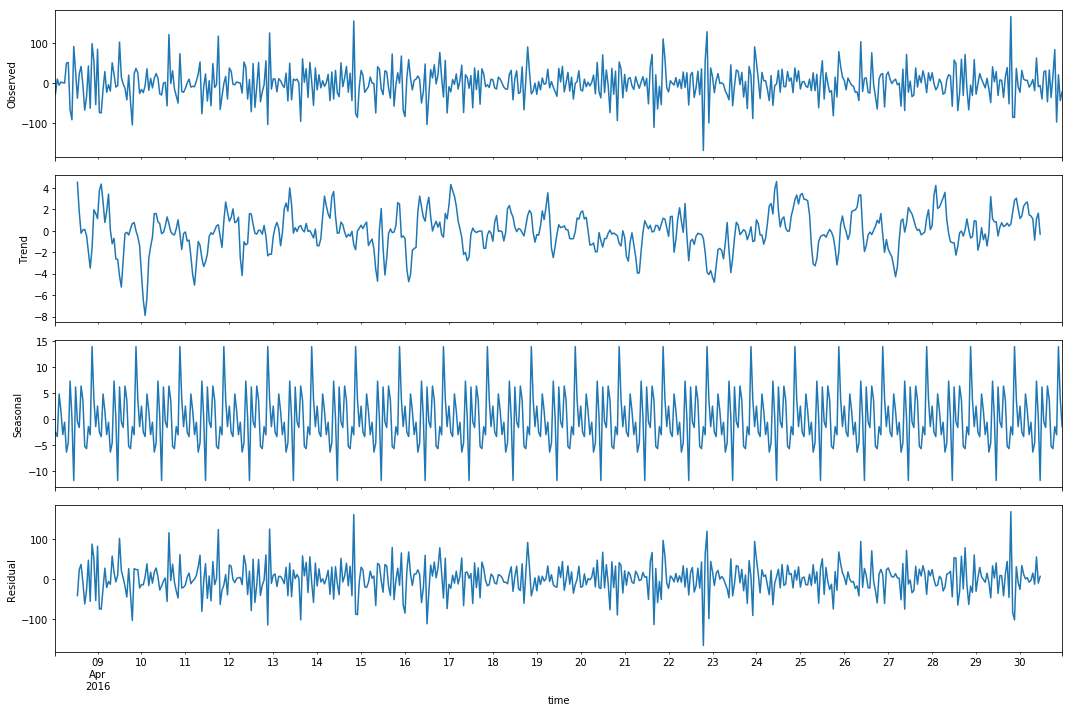

In [58]:
tripdata_cluster_2['residuals_dif2'] = tripdata_cluster_2.loc[date_from:date_to].residuals_dif-tripdata_cluster_2.loc[date_from:date_to].residuals_dif.shift(1)
plt.figure(figsize(15, 10))
sm.tsa.seasonal_decompose(tripdata_cluster_2[169:].loc[date_from:date_to, 'residuals_dif2'], freq = 24).plot();

In [59]:
print("Dickey - Fuller test: p = ", sm.tsa.stattools.adfuller(tripdata_cluster_2.loc[date_from:date_to].residuals_dif2[169:])[1])

('Dickey - Fuller test: p = ', 5.451045809546599e-20)


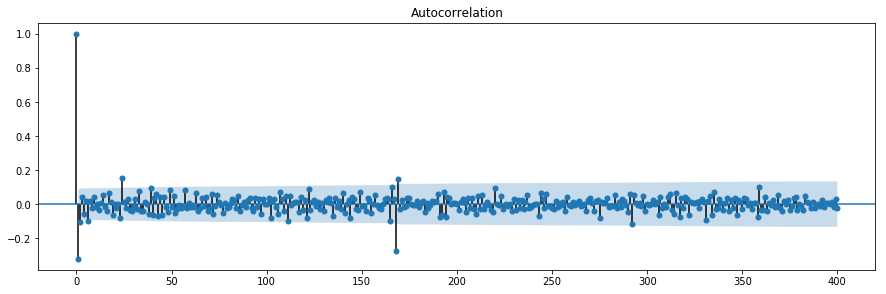

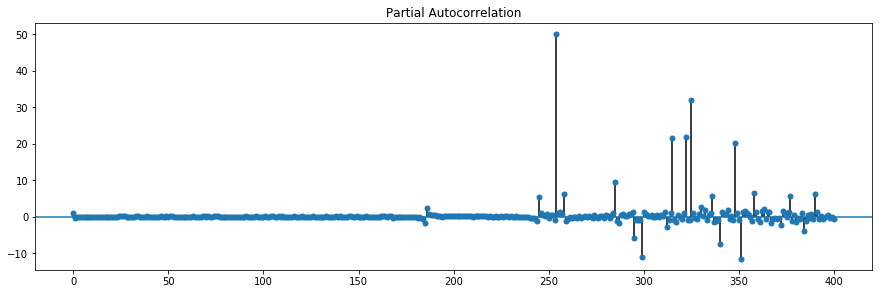

In [60]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(tripdata_cluster_2.loc[date_from:date_to].residuals_dif2[169:].values.squeeze(), lags = 400, ax = ax)
plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(tripdata_cluster_2.loc[date_from:date_to].residuals_dif2[169:].values.squeeze(), lags = 400, ax = ax)
plt.show()

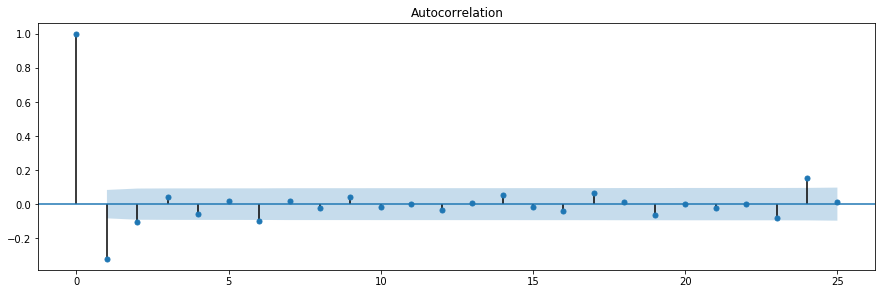

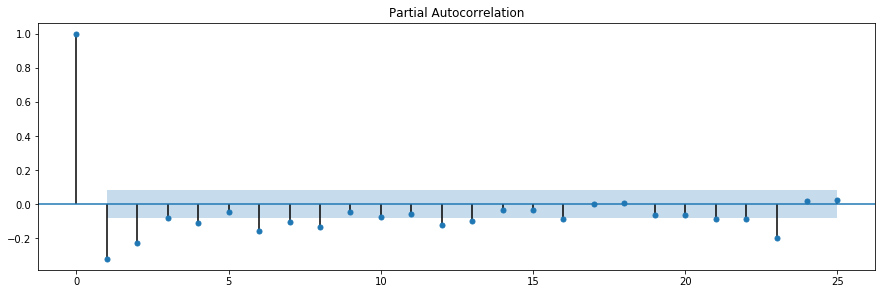

In [61]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(tripdata_cluster_2.loc[date_from:date_to].residuals_dif2[169:].values.squeeze(), lags = 25, ax = ax)
plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(tripdata_cluster_2.loc[date_from:date_to].residuals_dif2[169:].values.squeeze(), lags = 25, ax = ax)
plt.show()

In [62]:
Q = 1
q = 2
P = 0
p = 2

ps = range(0, p+1)
d = 0
qs = range(0, q+1)
Ps = range(0, P+1)
D = 0
Qs = range(0, Q+1)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

18

In [63]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #we need try except since the model will not not fit on some parameter sets
    try:
        model=sm.tsa.statespace.SARIMAX(
                                        endog=tripdata_cluster_2.loc[date_from:date_to].counts, 
                                        exog = asarray(tripdata_features.loc[date_from:date_to]),
                                        order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24), 
                                        initialization='approximate_diffuse'
                                       ).fit(disp=False)
    #вdisplay parameters on which the model didn't fit and proceed to the next set
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    print 'parameters:{} have aic value {}'.format(param, aic)
    #saving the best model, aic, parameters
    if aic < best_aic:
        best_model_cluster_2 = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

parameters:(0, 0, 0, 0) have aic value 10188.7194581
parameters:(0, 0, 0, 1) have aic value 9458.66594568
parameters:(0, 1, 0, 0) have aic value 9322.17525726
parameters:(0, 1, 0, 1) have aic value 8784.63812639
parameters:(0, 2, 0, 0) have aic value 8821.52723736
parameters:(0, 2, 0, 1) have aic value 8655.93863219
parameters:(1, 0, 0, 0) have aic value 7470.33985489
parameters:(1, 0, 0, 1) have aic value 7507.5734547
parameters:(1, 1, 0, 0) have aic value 7191.65006626
parameters:(1, 1, 0, 1) have aic value 7242.55301476
parameters:(1, 2, 0, 0) have aic value 7151.77344378
parameters:(1, 2, 0, 1) have aic value 7223.0422644
parameters:(2, 0, 0, 0) have aic value 7418.44236204
parameters:(2, 0, 0, 1) have aic value 7428.76062228
('wrong parameters:', (2, 1, 0, 0))
('wrong parameters:', (2, 1, 0, 1))
parameters:(2, 2, 0, 0) have aic value 7142.83226035
parameters:(2, 2, 0, 1) have aic value 7211.57589972
CPU times: user 8min 36s, sys: 1.9 s, total: 8min 38s
Wall time: 4min 25s


In [64]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True))

      parameters           aic
14  (2, 2, 0, 0)   7142.832260
10  (1, 2, 0, 0)   7151.773444
8   (1, 1, 0, 0)   7191.650066
15  (2, 2, 0, 1)   7211.575900
11  (1, 2, 0, 1)   7223.042264
9   (1, 1, 0, 1)   7242.553015
12  (2, 0, 0, 0)   7418.442362
13  (2, 0, 0, 1)   7428.760622
6   (1, 0, 0, 0)   7470.339855
7   (1, 0, 0, 1)   7507.573455
5   (0, 2, 0, 1)   8655.938632
3   (0, 1, 0, 1)   8784.638126
4   (0, 2, 0, 0)   8821.527237
2   (0, 1, 0, 0)   9322.175257
1   (0, 0, 0, 1)   9458.665946
0   (0, 0, 0, 0)  10188.719458


In [65]:
print(best_model_cluster_2.summary())

                           Statespace Model Results                           
Dep. Variable:                 counts   No. Observations:                  720
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -3497.416
Date:                Sat, 06 Jul 2019   AIC                           7142.832
Time:                        16:44:04   BIC                           7481.697
Sample:                    04-01-2016   HQIC                          7273.653
                         - 04-30-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            25.6969      6.325      4.063      0.000      13.301      38.093
x2            25.3527      5.903      4.295      0.000      13.782      36.923
x3             0.9843      3.732      0.264      0.7

Критерий Стьюдента: p=0.187925
Критерий Дики-Фуллера: p=0.000000


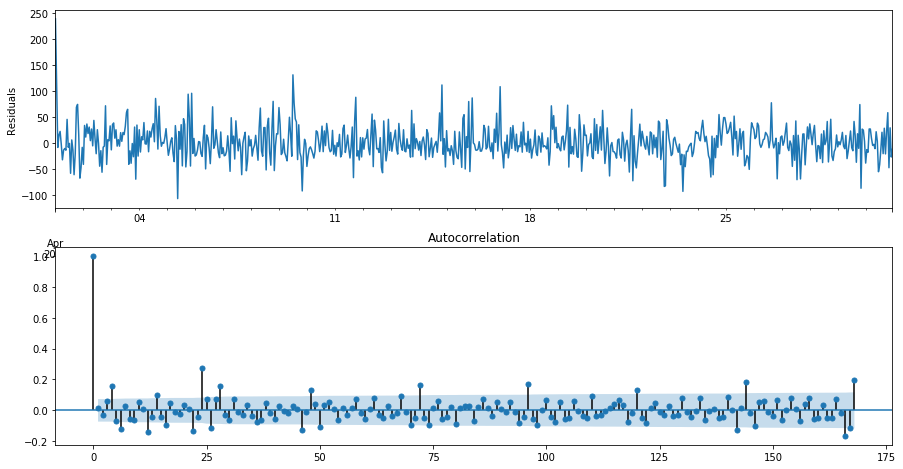

In [66]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model_cluster_2.resid.plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model_cluster_2.resid.values.squeeze(), lags=168, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model_cluster_2.resid, 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model_cluster_2.resid)[1])

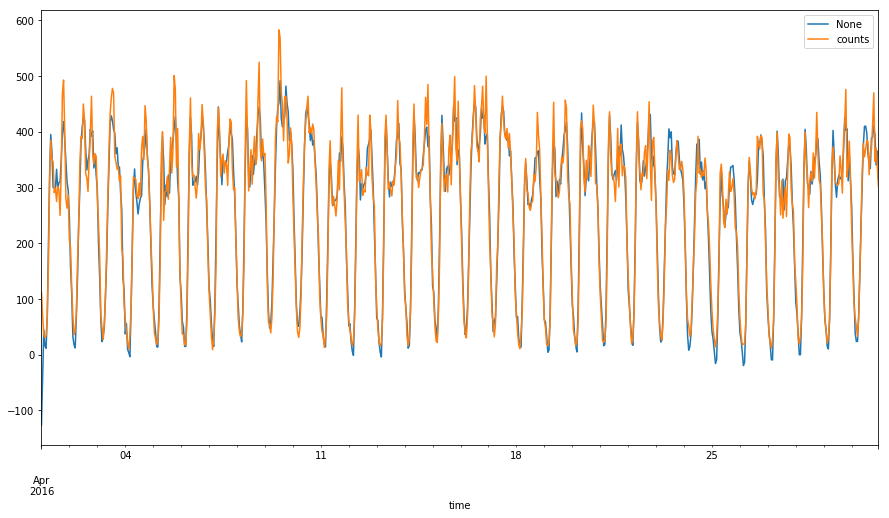

In [67]:
best_model_cluster_2.fittedvalues.plot()
tripdata_cluster_2.loc[date_from:date_to]['counts'].plot()
legend()

<h5>Cluster 3

<Figure size 1080x504 with 0 Axes>

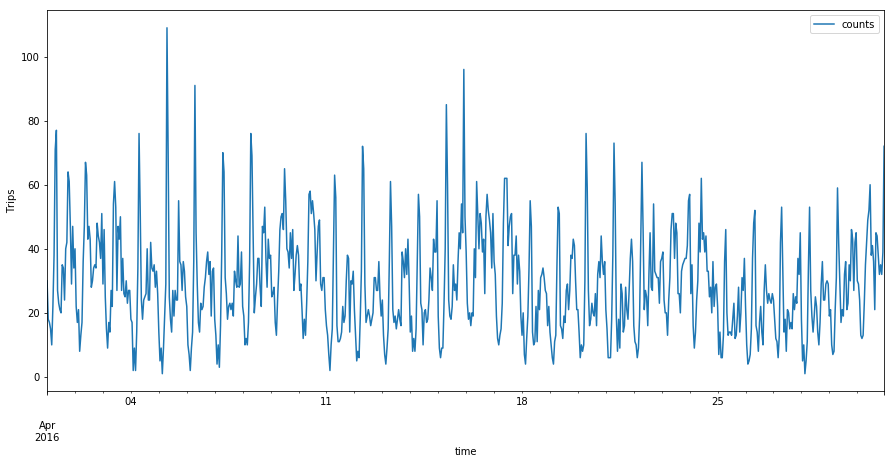

In [68]:
tripdata_cluster_3 = pd.DataFrame(tripdata[str(centers_of_clusters[2])])
tripdata_cluster_3 = tripdata_cluster_3.rename({str(centers_of_clusters[2]):"counts"}, axis='columns')

plt.figure(figsize(15,7))
tripdata_cluster_3.loc[date_from:date_to].plot()
plt.ylabel('Trips')
pylab.show()

In [69]:
X = tripdata_features.loc[date_from:date_to]
y = tripdata_cluster_3.loc[date_from:date_to].counts

linear_model = LinearRegression()
model_fit = linear_model.fit(X, y)
y_predicted = model_fit.predict(X)

print model_fit.score(X, y)

0.7674889046479516


In [70]:
tripdata_cluster_3.loc[date_from:date_to,'prediction'] = y_predicted
tripdata_cluster_3.loc[date_from:date_to,'residuals'] = y - y_predicted

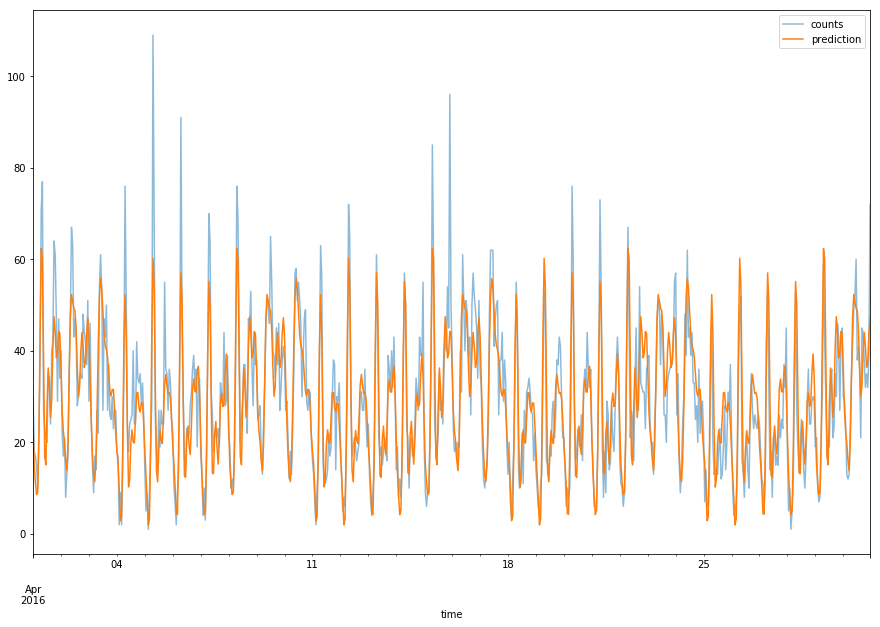

In [71]:
plt.figure(figsize(15, 10))
tripdata_cluster_3.loc[date_from:date_to]['counts'].plot(alpha = 0.5, legend = True)
tripdata_cluster_3.loc[date_from:date_to]['prediction'].plot(legend = True)

<Figure size 1080x720 with 0 Axes>

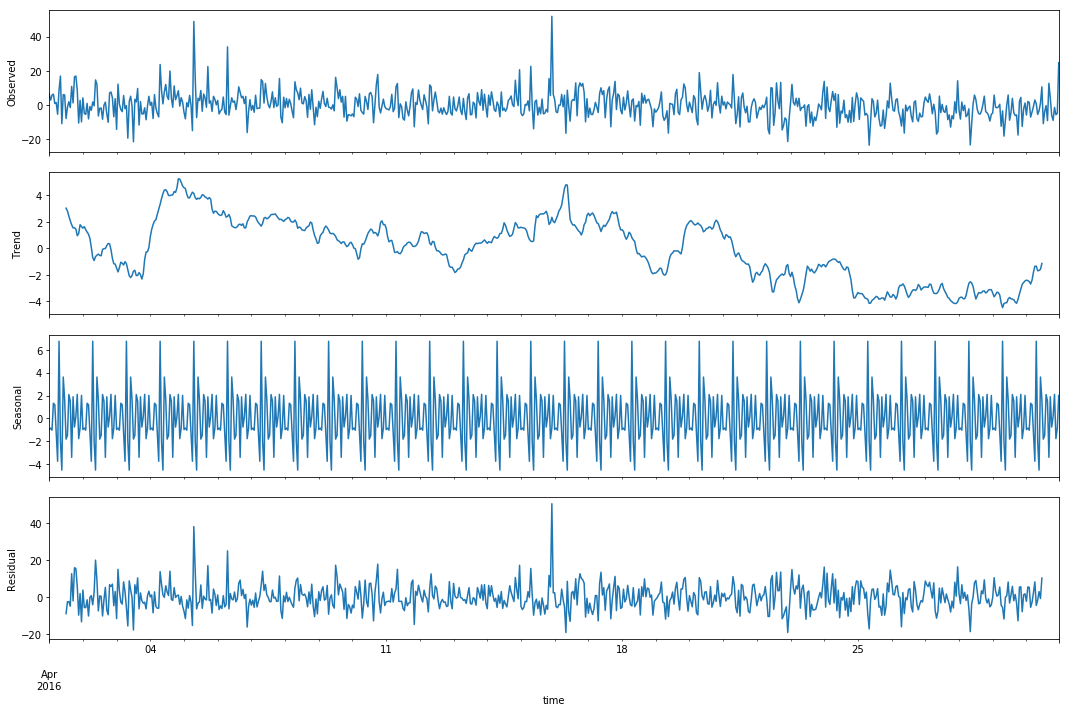

In [72]:
plt.figure(figsize(15, 10))
sm.tsa.seasonal_decompose(tripdata_cluster_3.loc[date_from:date_to,'residuals'], freq = 24).plot();

In [73]:
print "Dickey - Fuller test: p = ", sm.tsa.stattools.adfuller(tripdata_cluster_3.loc[date_from:date_to].counts)[1]

Dickey - Fuller test: p =  0.00032419419051291044


<Figure size 1080x720 with 0 Axes>

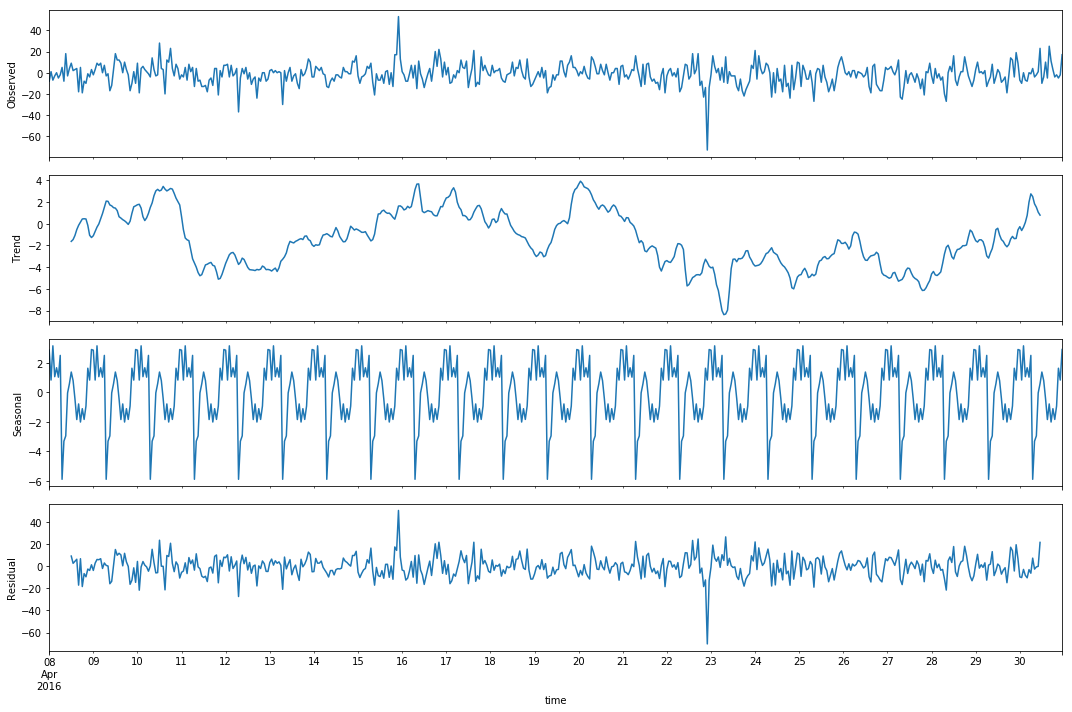

In [74]:
tripdata_cluster_3['residuals_dif'] = tripdata_cluster_3.loc[date_from:date_to].residuals - tripdata_cluster_3.residuals.shift(168)
plt.figure(figsize(15, 10))
sm.tsa.seasonal_decompose(tripdata_cluster_3[168:].loc[date_from:date_to, 
                                                       'residuals_dif'], freq = 24).plot();

<Figure size 1080x720 with 0 Axes>

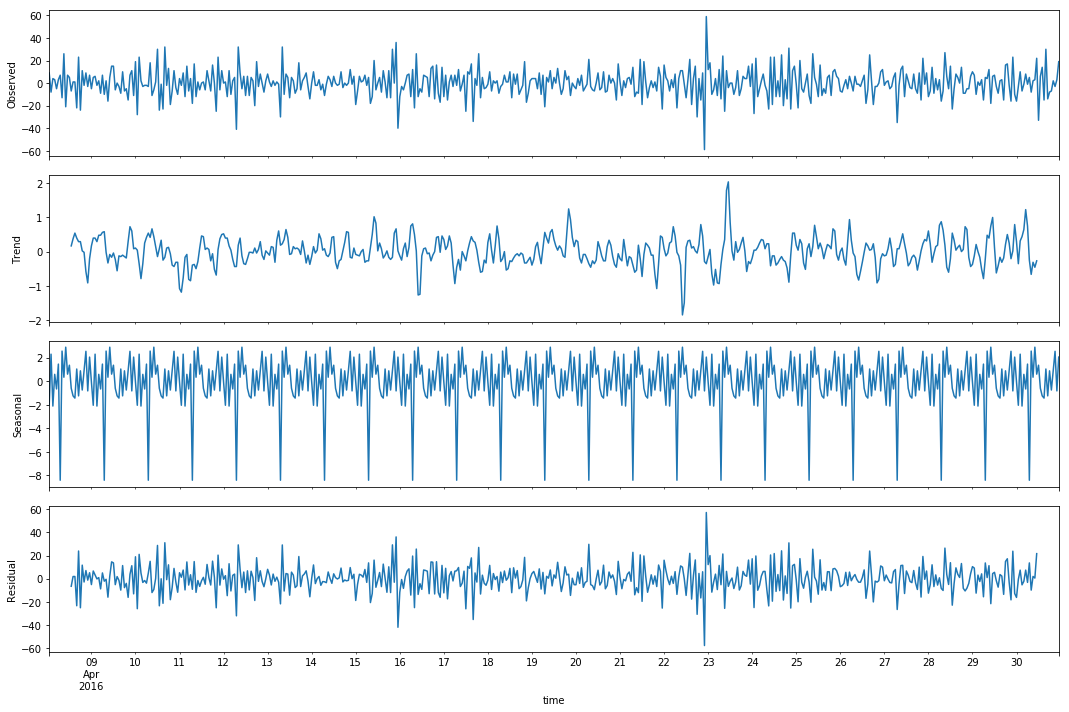

In [75]:
tripdata_cluster_3['residuals_dif2'] = tripdata_cluster_3.loc[date_from:date_to].residuals_dif-tripdata_cluster_3.loc[date_from:date_to].residuals_dif.shift(1)
plt.figure(figsize(15, 10))
sm.tsa.seasonal_decompose(tripdata_cluster_3[169:].loc[date_from:date_to, 'residuals_dif2'], freq = 24).plot();

In [76]:
print("Dickey - Fuller test: p = ", sm.tsa.stattools.adfuller(tripdata_cluster_3.loc[date_from:date_to].residuals_dif2[169:])[1])

('Dickey - Fuller test: p = ', 6.298854772697772e-17)


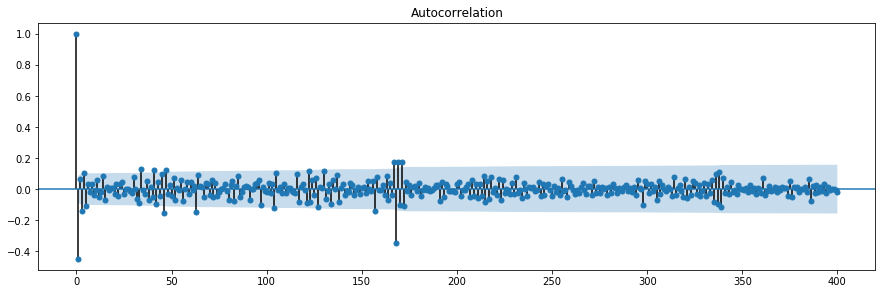

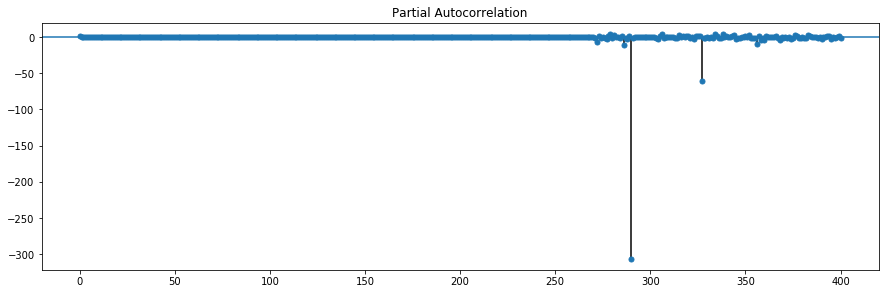

In [77]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(tripdata_cluster_3.loc[date_from:date_to].residuals_dif2[169:].values.squeeze(), lags = 400, ax = ax)
plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(tripdata_cluster_3.loc[date_from:date_to].residuals_dif2[169:].values.squeeze(), lags = 400, ax = ax)
plt.show()

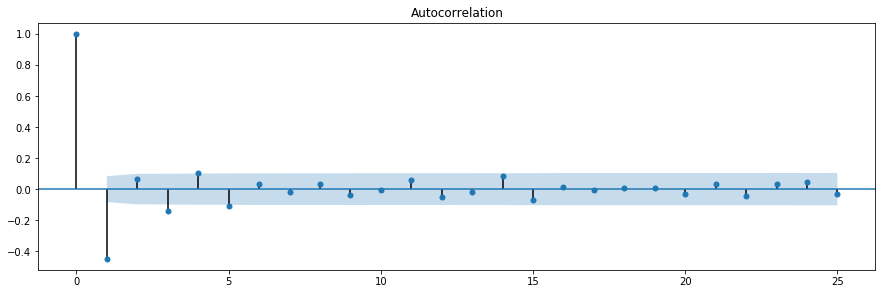

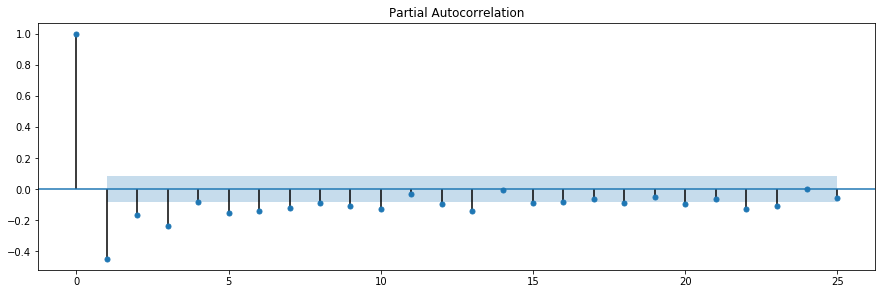

In [78]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(tripdata_cluster_3.loc[date_from:date_to].residuals_dif2[169:].values.squeeze(), lags = 25, ax = ax)
plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(tripdata_cluster_3.loc[date_from:date_to].residuals_dif2[169:].values.squeeze(), lags = 25, ax = ax)
plt.show()

In [79]:
Q = 1
q = 1
P = 0
p = 3

ps = range(0, p+1)
d = 0
qs = range(0, q+1)
Ps = range(0, P+1)
D = 0
Qs = range(0, Q+1)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

16

In [80]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #we need try except since the model will not not fit on some parameter sets
    try:
        model=sm.tsa.statespace.SARIMAX(
                                        endog=tripdata_cluster_3.loc[date_from:date_to].counts, 
                                        exog = asarray(tripdata_features.loc[date_from:date_to]),
                                        order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24), 
                                        initialization='approximate_diffuse'
                                       ).fit(disp=False)
    #вdisplay parameters on which the model didn't fit and proceed to the next set
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    print 'parameters:{} have aic value {}'.format(param, aic)
    #saving the best model, aic, parameters
    if aic < best_aic:
        best_model_cluster_3 = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

parameters:(0, 0, 0, 0) have aic value 7063.92005202
parameters:(0, 0, 0, 1) have aic value 6615.7829566
parameters:(0, 1, 0, 0) have aic value 6469.79976655
parameters:(0, 1, 0, 1) have aic value 6283.23174093
parameters:(1, 0, 0, 0) have aic value 5513.97473938
parameters:(1, 0, 0, 1) have aic value 5664.91471224
parameters:(1, 1, 0, 0) have aic value 5109.61457189
parameters:(1, 1, 0, 1) have aic value 5274.83077699
parameters:(2, 0, 0, 0) have aic value 5383.2217665
parameters:(2, 0, 0, 1) have aic value 5523.91824892
('wrong parameters:', (2, 1, 0, 0))
('wrong parameters:', (2, 1, 0, 1))
parameters:(3, 0, 0, 0) have aic value 5281.60959845
parameters:(3, 0, 0, 1) have aic value 5429.6181005
parameters:(3, 1, 0, 0) have aic value 5119.73450351
parameters:(3, 1, 0, 1) have aic value 5282.4848478
CPU times: user 7min 8s, sys: 1.56 s, total: 7min 10s
Wall time: 3min 40s


In [81]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True))

      parameters          aic
6   (1, 1, 0, 0)  5109.614572
12  (3, 1, 0, 0)  5119.734504
7   (1, 1, 0, 1)  5274.830777
10  (3, 0, 0, 0)  5281.609598
13  (3, 1, 0, 1)  5282.484848
8   (2, 0, 0, 0)  5383.221767
11  (3, 0, 0, 1)  5429.618101
4   (1, 0, 0, 0)  5513.974739
9   (2, 0, 0, 1)  5523.918249
5   (1, 0, 0, 1)  5664.914712
3   (0, 1, 0, 1)  6283.231741
2   (0, 1, 0, 0)  6469.799767
1   (0, 0, 0, 1)  6615.782957
0   (0, 0, 0, 0)  7063.920052


In [82]:
print(best_model_cluster_3.summary())

                           Statespace Model Results                           
Dep. Variable:                 counts   No. Observations:                  720
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -2482.807
Date:                Sat, 06 Jul 2019   AIC                           5109.615
Time:                        16:49:27   BIC                           5439.321
Sample:                    04-01-2016   HQIC                          5236.899
                         - 04-30-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             6.0934      0.565     10.792      0.000       4.987       7.200
x2             1.4932      0.568      2.629      0.009       0.380       2.606
x3             0.3977      0.548      0.726      0.4

Критерий Стьюдента: p=0.877399
Критерий Дики-Фуллера: p=0.000000


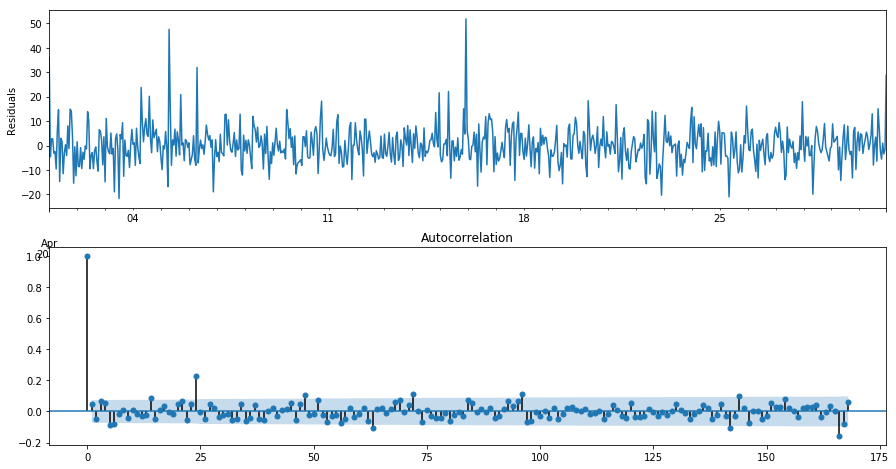

In [83]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model_cluster_3.resid.plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model_cluster_3.resid.values.squeeze(), lags=168, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model_cluster_3.resid, 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model_cluster_3.resid)[1])

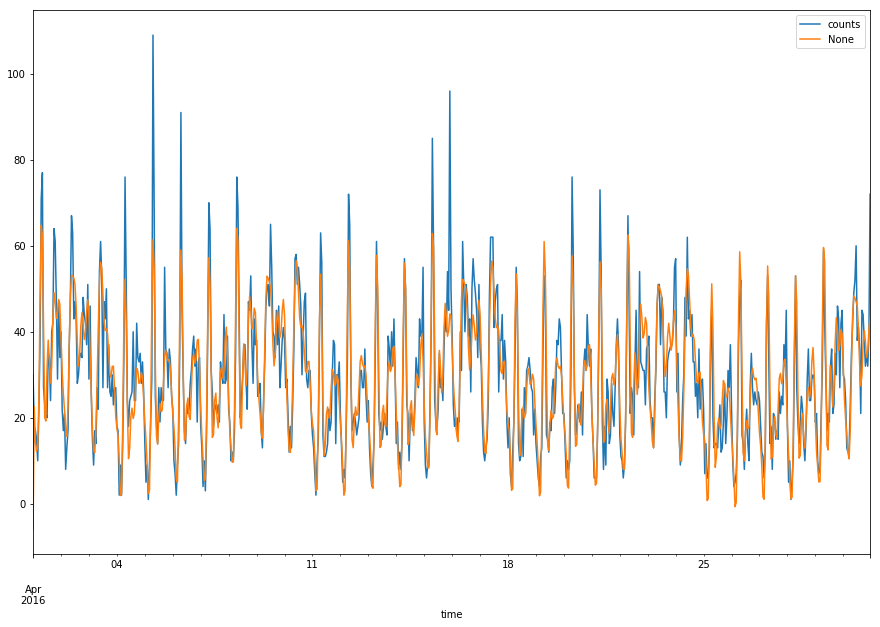

In [84]:
plt.figure(figsize(15, 10))
tripdata_cluster_3.loc[date_from:date_to]['counts'].plot()
best_model_cluster_3.fittedvalues.plot()

legend()

<h1> 6. Prediction

In [129]:
best_model_cluster_1.model.seasonal_order

(0, 0, 0, 24)

In [131]:
models = []
models.append([best_model_cluster_1.model.order, best_model_cluster_1.model.seasonal_order, 
                                                 best_model_cluster_1.params])
models.append([best_model_cluster_2.model.order, best_model_cluster_2.model.seasonal_order, 
                                                 best_model_cluster_2.params])
models.append([best_model_cluster_3.model.order, best_model_cluster_3.model.seasonal_order, 
                                                 best_model_cluster_3.params])
df_models = pd.DataFrame(models)
df_models.columns = ['order', 'seasonal_order', 'params']

In [132]:
df_models

order seasonal_order                                             params
0  (1, 0, 2)  (0, 0, 0, 24)  x1         155.375905
x2          48.374967
x3...
1  (2, 0, 2)  (0, 0, 0, 24)  x1         25.696894
x2         25.352669
x3  ...
2  (1, 0, 1)  (0, 0, 0, 24)  x1         6.093440
x2         1.493152
x3    ...

In [234]:
inc = 0
err = 0
date_predict_to = datetime.strptime("2016-05-31 23:00:00", "%Y-%m-%d %H:%M:%S")

for item in mapping.index:
    region = mapping.loc[item].region
    data = tripdata[mapping.loc[item].region].loc[date_from:date_to]
    data_incl_prediction = tripdata[mapping.loc[item].region].loc[date_from:date_predict_to]
    cluster = mapping.loc[item].cluster
    order = df_models.loc[cluster].order
    seasonal_order = df_models.loc[cluster].seasonal_order
    
    try:
        model=sm.tsa.statespace.SARIMAX(
                                        endog=data, 
                                        exog = asarray(tripdata_features.loc[date_from:date_to]),
                                        order=order, 
                                        seasonal_order=seasonal_order, 
                                        initialization='approximate_diffuse'
                                       ).fit(disp=False)
    
    except Exception as inst:
            print type(inst)     
            print inst
            model=sm.tsa.statespace.SARIMAX(
                                        endog=data, 
                                        exog = asarray(tripdata_features.loc[date_from:date_to]),
                                        order=order, 
                                        seasonal_order=seasonal_order, 
                                        initialization='approximate_diffuse',
                                        enforce_stationarity = False,
                                        enforce_invertibility = False
                                       ).fit(disp=False)
            
    model_fitted = sm.tsa.statespace.SARIMAX(
                                        data_incl_prediction, 
                                        order = order, 
                                        seasonal_order=seasonal_order,
                                        exog = asarray(tripdata_features.loc[date_from:date_predict_to])
                                        ).filter(model.params)
    time_range = pd.date_range(start = '2016-04-30 23:00:00', end = '2016-05-31 17:00:00', freq='H')
    for time in time_range:
        predicted_data = model_fitted.predict(
                                    time + timedelta(hours=1), 
                                    time + timedelta(hours=6), 
                                    exog = asarray(tripdata_features.loc[time + timedelta(hours=1):time + timedelta(hours=6)]),
                                    dynamic=True)
        err = err + sum(abs(tripdata[mapping.loc[item].region].loc[time + timedelta(hours=1):time + timedelta(hours=6)] \
                                                  - predicted_data.round()))
    inc = inc + 1
    print inc, err

1 55472.0
2 135601.0
3 207167.0
4 259033.0
5 373581.0
6 525035.0
7 689739.0
8 868896.0
9 1101865.0
10 1218525.0
11 1296631.0
12 1331394.0
13 1365961.0
14 1397019.0
15 1418561.0
16 1440828.0
17 1639367.0
18 1868488.0
19 2108328.0
20 2400784.0
<type 'exceptions.ValueError'>
non-invertible starting MA parameters found with `enforce_invertibility` set to True.
21 2890336.0
22 3118987.0
23 3218298.0
<type 'exceptions.ValueError'>
Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.
24 3239988.0
25 3265989.0
26 3282988.0
<type 'exceptions.ValueError'>
Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.
27 3310015.0
28 3336760.0
29 3349173.0
30 3470794.0
31 3693497.0
32 3930696.0
33 4276711.0
34 4639331.0
35 5064401.0
36 5345283.0
37 5553928.0
38 5649942.0
<type 'exceptions.ValueError'>
Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.
39 5662716.0
40 5688976

<h4>Let's calculate the error Q-May

In [236]:
Q_may = err / (102*739*6)
print Q_may

23.177837034678554


<h1> Predicting May

In [331]:
inc = 0
err = 0
results = []
date_predict_to = datetime.strptime("2016-06-30 23:00:00", "%Y-%m-%d %H:%M:%S")

for item in mapping.index:
    region = mapping.loc[item].region
    data = tripdata[mapping.loc[item].region].loc[date_from:date_to]
    data_incl_prediction = tripdata[mapping.loc[item].region].loc[date_from:date_predict_to]
    cluster = mapping.loc[item].cluster
    order = df_models.loc[cluster].order
    seasonal_order = df_models.loc[cluster].seasonal_order
    
    try:
        model=sm.tsa.statespace.SARIMAX(
                                        endog=data, 
                                        exog = asarray(tripdata_features.loc[date_from:date_to]),
                                        order=order, 
                                        seasonal_order=seasonal_order, 
                                        initialization='approximate_diffuse'
                                       ).fit(disp=False)
    
    except Exception as inst:
            print type(inst)     
            print inst
            model=sm.tsa.statespace.SARIMAX(
                                        endog=data, 
                                        exog = asarray(tripdata_features.loc[date_from:date_to]),
                                        order=order, 
                                        seasonal_order=seasonal_order, 
                                        initialization='approximate_diffuse',
                                        enforce_stationarity = False,
                                        enforce_invertibility = False
                                       ).fit(disp=False)
            
    model_fitted = sm.tsa.statespace.SARIMAX(
                                        data_incl_prediction, 
                                        order = order, 
                                        seasonal_order=seasonal_order,
                                        exog = asarray(tripdata_features.loc[date_from:date_predict_to])
                                        ).filter(model.params)
    time_range = pd.date_range(start = '2016-05-31 23:00:00', end = '2016-06-30 17:00:00', freq='H')
    for time in time_range:
        predicted_data = model_fitted.predict(
                                    time + timedelta(hours=1), 
                                    time + timedelta(hours=6), 
                                    exog = asarray(tripdata_features.loc[time + timedelta(hours=1):time + timedelta(hours=6)]),
                                    dynamic=True)
        


        df_temp = pd.DataFrame(predicted_data)
        df_temp.index.name = 'time'
        df_temp.columns = ['predicted_count']
        df_temp['idx'] = [1, 2, 3, 4, 5, 6]

        for i in range(0,6):
            id = str(region) + '_' \
            + str(time.year) + '-' + str(time.month) + '-' + str(time.day) + '_' \
            + str(time.hour) + '_' + str(int(df_temp.iloc[i].idx))
            results.append([id, int(df_temp.iloc[i].predicted_count)])
    
        err = err + sum(abs(tripdata[mapping.loc[item].region].loc[time + timedelta(hours=1):time + timedelta(hours=6)] \
                                                  - predicted_data.round()))
    inc = inc + 1
    print inc, err

1 59747.0
2 133891.0
3 194810.0
4 239016.0
5 343117.0
6 494713.0
7 643428.0
8 830550.0
9 1054582.0
10 1169296.0
11 1236872.0
12 1267599.0
13 1294285.0
14 1324951.0
15 1343659.0
16 1363744.0
17 1552066.0
18 1774315.0
19 2050530.0
20 2344096.0
<type 'exceptions.ValueError'>
non-invertible starting MA parameters found with `enforce_invertibility` set to True.
21 2756926.0
22 2974971.0
23 3061169.0
<type 'exceptions.ValueError'>
Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.
24 3081391.0
25 3109225.0
26 3123548.0
<type 'exceptions.ValueError'>
Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.
27 3144591.0
28 3168852.0
29 3181178.0
30 3298457.0
31 3501720.0
32 3734441.0
33 4074861.0
34 4435528.0
35 4868707.0
36 5153686.0
37 5371825.0
38 5468798.0
<type 'exceptions.ValueError'>
Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.
39 5480167.0
40 5502074

In [351]:
result_table = pd.DataFrame(results)
result_table.columns = ['id', 'y']
result_table.loc[~(result_table['y'] > 0), 'y'] = 0

In [358]:
#result_table = result_table.set_index('id')
result_table.to_csv("sample_result.csv",",", index = False)

you can find my results here: https://inclass.kaggle.com/c/yellowtaxi/leaderboard <br>
Alexey Belov